# 1. File description 

To feed a model for it to predict a bot from a legit users I need the data to be labelled meaning each user in the dataset needs to have a 1 or 0 for bot/not bot. This file is meant to do so.

To label the data, multiple techniques are gonna be used and are divided in three. Manual, semi-manual and automatic labelling. 


## 0. Import module and setting notebook preferences

### 0.1 Import modules

In [1]:
import src.useful as su
import src.labelling as sl
import src.image as si
import src.model as sm 

import pandas as pd 
import numpy as np
from scipy.stats import entropy
import sqlite3 
from datetime import datetime
import time

import plotly.io as pio
import plotly.express as px

from imagededup.methods import PHash
from PIL import Image, ImageDraw, ImageFont, UnidentifiedImageError

import os
import shutil
import joblib


from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBClassifier
import cleanlab

from tqdm import tqdm 

from IPython.display import Image as IImage, display, clear_output
import pyautogui
import cv2
import numpy as np
from PIL import Image
from itertools import product
import re

import clipboard

### 0.2 Notebook preferences

In [2]:
pd.set_option("display.max_columns", None)
pio.templates.default = "plotly_dark"

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

# Creating template user to show steps with consistent data
username_template = 'accurate-eccentric-lion'

### 0.0 Create file with photos

In [3]:
# np.random.shuffle(last12_photos_paths)
# for path in tqdm(last12_photos_paths[:50000]): 
#     shutil.copy(path, path.replace('data/photos/user_last_12_posts/', 'test_folder_photos/'))

In [4]:
# asdf

## 1. Manual labelling 

To label the data manually, the process has to be fast, I need to see all the information about the users condensed in one summary. For that, I chose to create for each user an image with their attributes and their photos. I'll then create a script to open one image by one, and then chose bot/not bot/maybe bot with keyboard arrows. 



In [5]:
# Load the data and display only the one from a 
query = '''
select 
    * 
from clean_comments_users_last12
'''

df_main = pd.read_sql_query(query, con)

### 1.1 Generate summary

I'm going to use the profile of a bot for the image demo. The account is still live but hasn't been active for about 9 months, at last the last comment on their post is. This is the developed function from [generate_summary.py](https://github.com/marclelamy/instagram_bot_classification/blob/main/3.1_generate_summary.py)

First, create a blank image, define font.

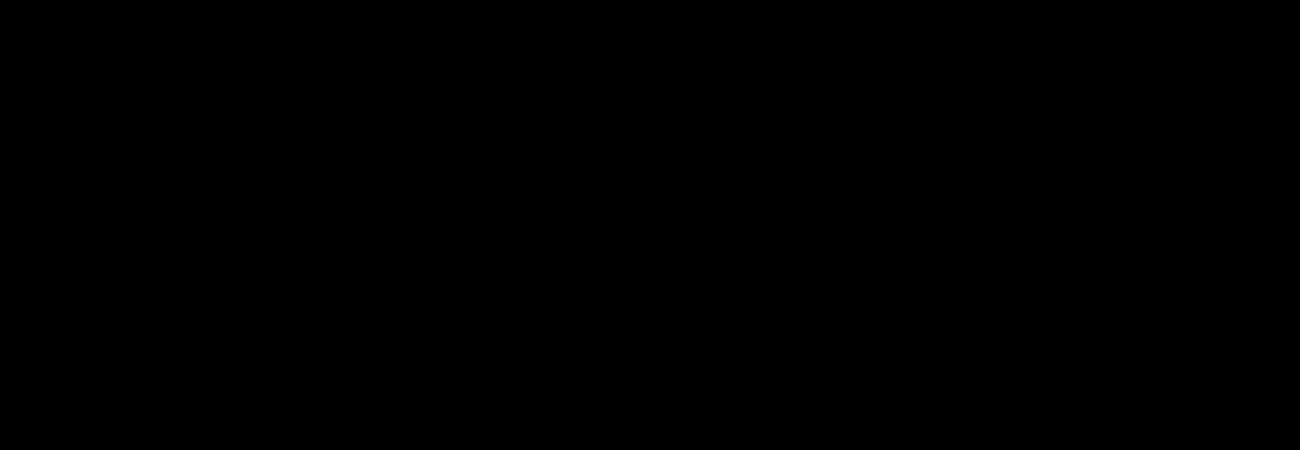

In [6]:
global_image = Image.new("RGB", (1300, 450), "black")
draw = ImageDraw.Draw(global_image)
font = ImageFont.truetype("assets/OpenSans-Light.ttf", 15)

global_image

Add the profile picture 

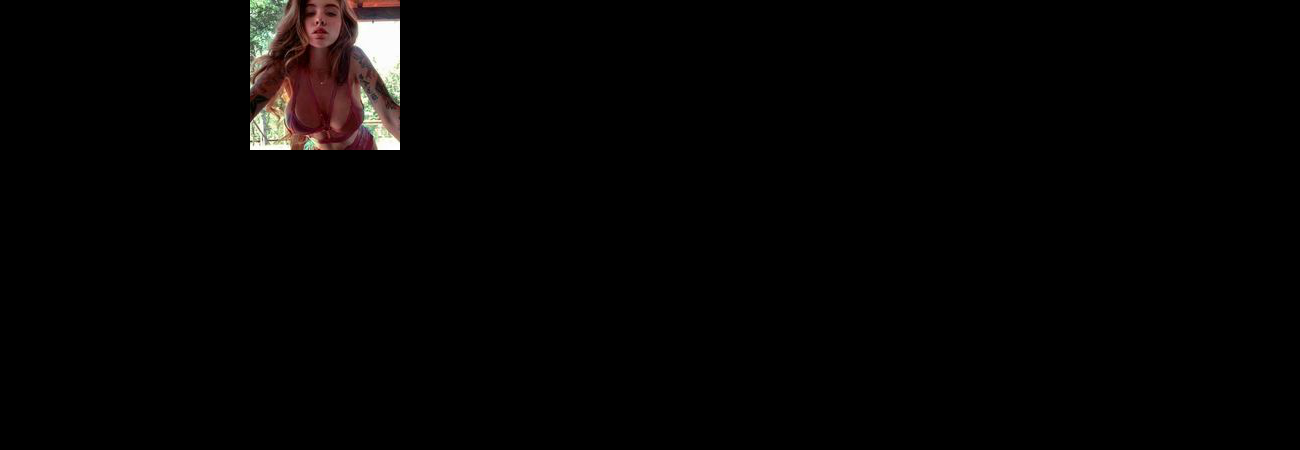

In [7]:
df_user = df_main[df_main["username"]==username_template].reset_index(drop=True)

# Open user pp and add it to the global image
try:
    path = f"data/photos/user_profile_pictures/{username_template}_pp_user_photo.png"
    profile_pic = Image.open(path)
    global_image.paste(profile_pic, (250, 0))
except (FileNotFoundError, UnidentifiedImageError): 
    pass

global_image

Adding twelve other photos 

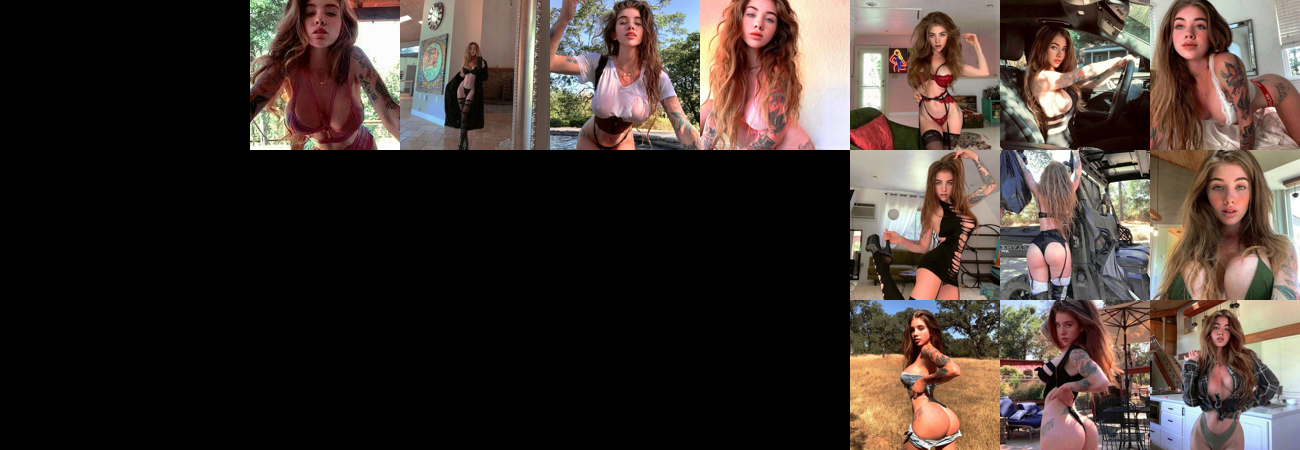

In [8]:
# Creating a list of position to add the photos on the global image
positions = []
for x in range(850, 1300, 150):
    for y in range(0, 450, 150):
        positions.append((x, y))


# Loop through each image and add it to the global image
for image_num in range(12):
    path = f"data/photos/user_last_12_posts/{username_template}_{str(image_num)}_user_photo.png"

    try:
        if os.path.exists(path):
            img = Image.open(path)
            if image_num < 9:
                global_image.paste(img.resize((150, 150)), positions[image_num])
            elif image_num == 9:
                global_image.paste(img.resize((150, 150)), (400, 0))
            elif image_num == 10:   
                global_image.paste(img.resize((150, 150)), (550, 0))
            elif image_num == 11:
                global_image.paste(img.resize((150, 150)), (700, 0))
    except (OSError, UnidentifiedImageError) as e: # For truncated image file
        pass

global_image

Adding screenshot of the landing page of the url in bio

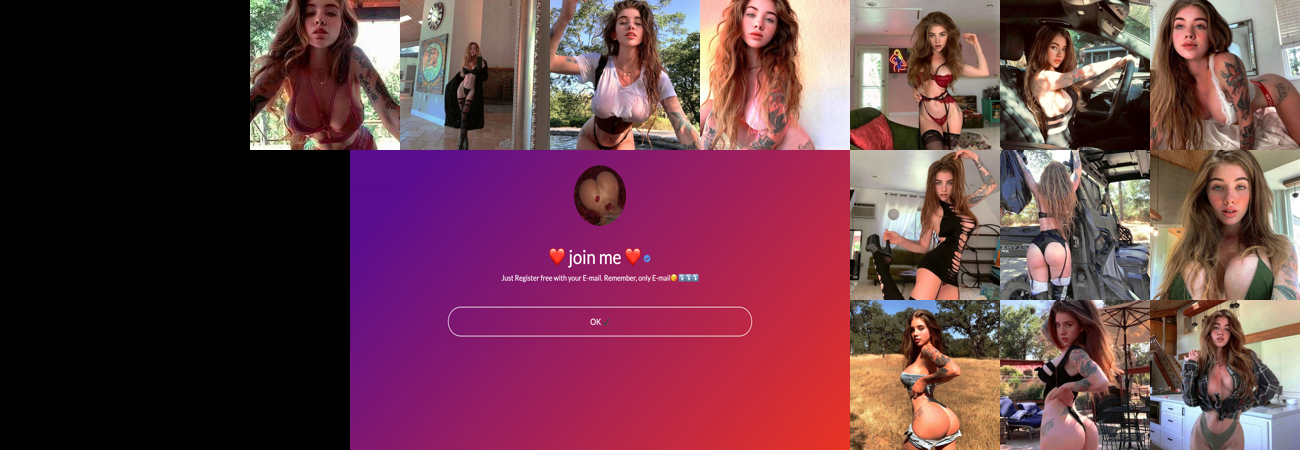

In [9]:
# Open screenshot, resize it, add it to global_image 
path = f"data/photos/bio_url_screenshot/{username_template}_website_photo.png"
try:
    screenshot = Image.open(path)
    global_image.paste(screenshot.resize((500, 300)), (350, 150))
except (UnidentifiedImageError, FileNotFoundError):
    pass

global_image

In [10]:
df_user

,username,full_name,biography,follow_count,follower_count,pronouns,domain,comment,comment_likes,comment_wo_emoji,emoji_dict,emoji_count,emoji_count_distinct,emoji,time_difference,comment_posted_time,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_verified,verified_user,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_is_video,posts_video_views,posts_likes,posts_comment_count,posts_tagg_count,posts_posted_time
0,accurate-eccentric-lion,Mary Bawerman,23 🎉y 😧\nColorado CO USA ☄️\n💙 Subscribe my In...,37.0,445.0,"ulrikkeballi, ulrikkeballi, ulrikkeballi, ulri...",bit.ly,👁arrangements,309,arrangements,{'👁': 1},1,1,👁,20,2021-12-12 03:47:45+00:00,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,UNKNOWN,accurate-eccentric-lion,accurate-eccentric-lion,accurate-eccentric-lion,0.0,0.0,"0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0","151,107,168,105,78,88,98,108,70,77,123,69","23.0,3.0,12.0,2.0,4.0,2.0,8.0,12.0,3.0,3.0,12....","0,0,0,0,0,0,0,0,0,0,0,0","2021-08-23 21:26:27,2021-08-23 21:26:05,2021-0..."


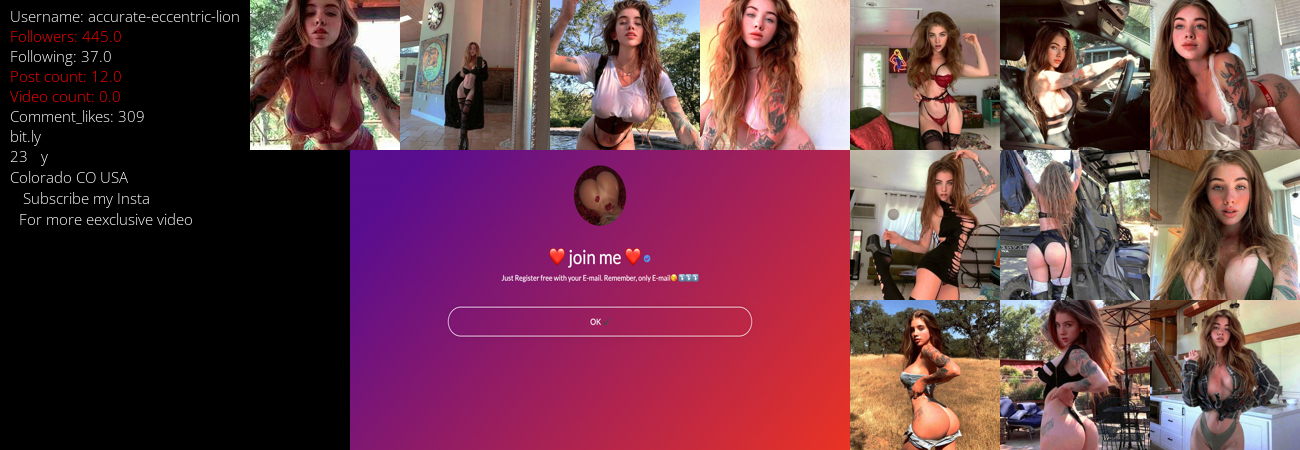

In [11]:
# Add basic information 
username = df_user.loc[0, "username"]
draw.text((10, 5), f"Username: {username}", font=font, fill="white")

follower_count = df_user.loc[0, "follower_count"]
color = "white" if follower_count > 800 else "red"
draw.text((10, 25), f"Followers: {follower_count:,}", font=font, fill=color)

follow_count = df_user.loc[0, "follow_count"]
draw.text((10, 45), f"Following: {follow_count:,}", font=font, fill="white")

post_count = df_user.loc[0, "post_count"]
color = "white" if post_count > 16 else "red"
draw.text((10, 65), f"Post count: {post_count}", font=font, fill=color)

video_count = df_user.loc[0, "video_count"]
color = "white" if video_count > 0 else "red"
draw.text((10, 85), f"Video count: {video_count}", font=font, fill=color)

comment_likes = round(df_user["comment_likes"].mean())
color = "white" if 200 <= comment_likes < 450 else "red"
draw.text((10, 105), f"Comment_likes: {comment_likes}", font=font, fill="white")

domain = df_user.loc[0, "domain"]
draw.text((10, 125), f"{domain}", font=font, fill="white")

biography = df_user.loc[0, "biography"]
draw.text((10, 145), f"{biography}", font=font, fill="white")


global_image

Save image

In [12]:
# summary_path = f"data/photos/image_summary/{username_template}_image_summary.png"
# global_image.save(summary_path)

### 1.2 Manual labelling one by one

This is the process of labelling the users one by one, twice to eliminate human error. For this I made a script to open each image summary generated in the precedent step and label it with the arrows: `{'right': 'bot', 'up': 'legit', 'down': 'maybe'}`.

Look up for [3.2_manual_labelling.py](https://github.com/marclelamy/instagram_bot_classification/blob/main/3.2_manual_labelling.py)

## 2. Semi-manual labelling

Semi manual labelling needs data to work. 

This consists into looking at different attributes of users (like comment, bio, domain) and comparing them to other users to see the ones that share common features.

In [13]:
# # Reset labels df
# data = {'username': ['fakeusername1', 'fakeusername0'],
#         'label': ['1', '0'],
#         'time': [datetime.now(), datetime.now()],
#         'labelling_technique': ['fakelabelling', 'fakelabelling']
#         }

# # Trash, delete anytime
# data = {'username': ['masked-simple-mastodon', 'adorable-jade-beluga'],
#         'label': [1, 0],
#         'time': [datetime.now(), datetime.now()],
#         'labelling_technique': ['label_tbl_fake', 'label_tbl_fake']
#         }

# pd.DataFrame(data).to_sql('labels', con, if_exists='replace', index=False)

### 2.1 Old labelling

In [14]:
df_old_labels = pd.read_csv('data/old_labelling.csv')
df_old_labels = pd.concat([df_old_labels.iloc[:, [0, 1, 2, 5]], df_old_labels.iloc[:, [0, 3, 4, 5]].rename({'label2': 'label', 'time2': 'time'}, axis=1)], axis=0, ignore_index=False)
df_old_labels.to_sql('labels', con, if_exists='append', index=False)

7804

### Common sense columns



In [15]:
df_main = sl.load_main()

In [16]:
# asdf

### 2.x Image dupes

This is the step where I search for images that have been used more than one time. If user A is a bot and user B has the same photo as user A then user B is a bot.

#### 2.x.1 Finding all duplicated images

In [17]:
# # list all the photos folders
# last12_folder = 'data/photos/user_last_12_posts'
# pp_folder = 'data/photos/user_profile_pictures'
# # allphotos_folder = 'data/photos/all_photos'
# bio_screenshot_folder = 'data/photos/bio_url_screenshot'


# # Find duplicates and save the dictionary to re-use it later. (should use json instead of saving dict obj)
# phasher = PHash()
# for folder_path in tqdm([last12_folder, pp_folder, bio_screenshot_folder]): 
#     file_name = folder_path.split('/')[-1]

#     if os.path.isfile(f'data/photos/encodings_duplicates/{file_name}_duplicates.pkl'):
#         continue

#     if os.path.isfile(f'data/photos/encodings_duplicates/{file_name}_encodings.pkl'):
#         encodings = joblib.load(f'data/photos/encodings_duplicates/{file_name}_encodings.pkl')
#     else: 
#         encodings = phasher.encode_images(image_dir=folder_path)

#     duplicates = phasher.find_duplicates(encoding_map=encodings)
#     joblib.dump(duplicates, f'data/photos/encodings_duplicates/{file_name}_duplicates.pkl')


In [18]:
# # Test specific folders, can delete
# phasher = PHash()
# folder_path = '/Users/marclamy/Desktop/code/Instagram_bot_classification/data/photos/group_ids/74'
# encodings = phasher.encode_images(image_dir=folder_path)
# duplicates = phasher.find_duplicates(encoding_map=encodings)

In [19]:
pp_path_dupes = joblib.load(f'data/photos/encodings_duplicates/user_profile_pictures_duplicates.pkl')
last12_path_dupes = joblib.load('data/photos/encodings_duplicates/user_last_12_posts_duplicates.pkl')
# bio_url_path_dupes = joblib.load('data/photos/encodings_duplicates/bio_url_screenshot_duplicates.pkl')
# all_photo_dupes = {**pp_path_dupes, **last12_path_dupes, **bio_url_path_dupes}
all_photo_dupes = {**pp_path_dupes, **last12_path_dupes}#, **bio_url_path_dupes}
# all_path_dupes = joblib.load('data/photos/all_photos_duplicates.pkl')
# all_path_dupes = joblib.load('data/photos/bio_url_screenshot_duplicates.pkl')

dict_length = len(all_photo_dupes)
keys_with_values = len([key for key, value in all_photo_dupes.items() if len(value) > 0])

f'{dict_length = }\n{keys_with_values = }'

'dict_length = 449747\nkeys_with_values = 68146'

In [20]:
example_photo_key = all_photo_dupes['kickass-sheep-of-wonder_pp_user_photo.png'][0]
all_photo_dupes[example_photo_key][0]

'kickass-sheep-of-wonder_pp_user_photo.png'

In [21]:
example_photo_key = all_photo_dupes['wise-wolverine-of-force_8_user_photo.png'][0]
all_photo_dupes[example_photo_key][0]

'fat-mongoose-of-advance_6_user_photo.png'

There are duplicates in the dictionary meaning if photos A, B, C are the same, the dict will look like :

`{A: [B, C],
 B: [A, C],
 C: [A, B]}`



In [22]:
def rmv_photo_type(text): 
    extensions = ['_0_user_photo.png', '_1_user_photo.png', '_2_user_photo.png', '_3_user_photo.png', '_4_user_photo.png', '_5_user_photo.png', '_6_user_photo.png', '_7_user_photo.png', '_8_user_photo.png', '_9_user_photo.png', '_10_user_photo.png', '_11_user_photo.png', '_pp_user_photo.png', '_website_photo']
    for extension in extensions:
        text = text.replace(extension, '')
    return text


# Sorting every combinations so that duplicates show easily: A-B / B-A = A-B / A-B 
# all_photos_combination = [' - '.join(sorted([key, value])) for key, values in all_path_duplicated.items() for value in values if len(value) > 0]
# print(f'All photos combinations: {len(all_photos_combination):,}')

# Keeping usernames only so that if multiple photos of multiple users match, I only keep the users so less rows
# all_usernames_combination = [' - '.join([rmv_photo_type(combination[0]), rmv_photo_type(combination[1])]) for combination in (all_photos_combination)]
# print(f'All usernames combinations: {len(all_usernames_combination):,}')

# Removing dupes
# all_unique_photos_combination = list(set(all_photos_combination))
# print(f'All unique usernames combinations: {len(all_unique_photos_combination):,}')
# all_unique_photos_combination = [combination.split(' - ') for combination in all_unique_photos_combination]

In [23]:
def dupeless (dupes): 
    '''Remove keys also in list values of a dictionary'''
    for key, values in list(dupes.items()):
        if key in dupes.keys():
            if len(values) == 0:
                del dupes[key]
                continue
            for value in values:
                if value in dupes.keys():
                    del dupes[value]

    return dupes 

# Remove dupes
print(len(all_photo_dupes))
all_unique_photos_dupes = dupeless(all_photo_dupes)
print(len(all_unique_photos_dupes))

all_combinations = [[key, value] for key, values in all_unique_photos_dupes.items() for value in values]
len(all_combinations)

449747
27181


55594

Remove the type of the photo to only keep the username and remove the duplicates on the username/username_dupe subset

#### 2.x.2 Adding and ID for each photo group 

In [24]:
def rmv_photo_type(text): 
    '''Given a photo file name, extract the username out of it'''
    photos_extensions = ['_0_user_photo.png', '_1_user_photo.png', '_2_user_photo.png', '_3_user_photo.png', '_4_user_photo.png', '_5_user_photo.png', '_6_user_photo.png', '_7_user_photo.png', '_8_user_photo.png', '_9_user_photo.png', '_10_user_photo.png', '_11_user_photo.png', '_pp_user_photo.png', '_website_photo.png']
    for extension in photos_extensions:
        text = text.replace(extension, '')
    return text

In [25]:
# Create photos dupes dataframe
df_photos_dupes = pd.DataFrame(all_combinations, columns=['photo_name', 'photo_name_dupe'])
df_photos_dupes['username'] = df_photos_dupes['photo_name'].apply(rmv_photo_type)
df_photos_dupes['username_dupe'] = df_photos_dupes['photo_name_dupe'].apply(rmv_photo_type)


# Remove duplicate combinations
print(f'Before removing dupes: {df_photos_dupes.shape}')
df_usernames_dupes = df_photos_dupes[['username', 'username_dupe']].drop_duplicates()
print(f'After removing dupes: {df_usernames_dupes.shape}')

df_photos_dupes

Before removing dupes: (55594, 4)
After removing dupes: (49805, 2)


,photo_name,photo_name_dupe,username,username_dupe
0,kickass-sheep-of-wonder_pp_user_photo.png,enlightened-chocolate-dodo_pp_user_photo.png,kickass-sheep-of-wonder,enlightened-chocolate-dodo
1,kickass-sheep-of-wonder_pp_user_photo.png,interesting-bipedal-gorilla_pp_user_photo.png,kickass-sheep-of-wonder,interesting-bipedal-gorilla
2,kickass-sheep-of-wonder_pp_user_photo.png,placid-delicate-cheetah_pp_user_photo.png,kickass-sheep-of-wonder,placid-delicate-cheetah
3,kickass-sheep-of-wonder_pp_user_photo.png,fantastic-adder-from-uranus_pp_user_photo.png,kickass-sheep-of-wonder,fantastic-adder-from-uranus
4,kickass-sheep-of-wonder_pp_user_photo.png,rational-mastiff-of-hurricane_pp_user_photo.png,kickass-sheep-of-wonder,rational-mastiff-of-hurricane
...,...,...,...,...
55589,weightless-panda-of-leadership_7_user_photo.png,vigilant-sambar-of-youth_8_user_photo.png,weightless-panda-of-leadership,vigilant-sambar-of-youth
55590,nice-raptor-of-order_2_user_photo.png,curvy-opal-galago_4_user_photo.png,nice-raptor-of-order,curvy-opal-galago
55591,benevolent-satisfied-caiman_7_user_photo.png,kind-prophetic-pudu_1_user_photo.png,benevolent-satisfied-caiman,kind-prophetic-pudu
55592,greedy-rebel-mandrill_2_user_photo.png,peculiar-real-limpet_5_user_photo.png,greedy-rebel-mandrill,peculiar-real-limpet


In [26]:
# Counting how many dupes each photos has and ranking them descending
df_dupecount_per_photos = df_photos_dupes.groupby('photo_name', as_index=False).count().sort_values(['photo_name_dupe', 'photo_name'], ascending=False)
df_dupecount_per_photos = df_dupecount_per_photos[['photo_name', 'photo_name_dupe']].rename({'photo_name_dupe': 'dupe_count'}, axis=1)
display(df_dupecount_per_photos.head(20))

# Adding photo count to df_photos_dupes and sort the df from most dupe to less
df_photos_dupes = df_photos_dupes.merge(df_dupecount_per_photos).sort_values('dupe_count', ascending=False)

# Creating list with top 20 photos and their dupe count
top_20_photos = df_dupecount_per_photos[['photo_name', 'dupe_count']].values

,photo_name,dupe_count
13185,kickass-sheep-of-wonder_pp_user_photo.png,2451
3831,certain-quartz-marten_11_user_photo.png,1158
15111,meticulous-maroon-anaconda_pp_user_photo.png,525
25768,vehement-zippy-bison_0_user_photo.png,100
21556,slick-persimmon-mastiff_8_user_photo.png,100
14530,marvellous-charcoal-owl_pp_user_photo.png,100
9540,giga-jackdaw-of-politeness_11_user_photo.png,78
10119,great-tremendous-roadrunner_7_user_photo.png,77
1323,angelic-petrel-of-aptitude_10_user_photo.png,77
18935,quick-devout-bettong_9_user_photo.png,76


In [27]:
# Adding an ID for all similar photos
unique_photos_names = df_photos_dupes['photo_name'].unique()
photos_group_ids = {photo_name: group_id for group_id, photo_name in enumerate(unique_photos_names)}
df_photos_dupes['group_id'] = df_photos_dupes['photo_name'].apply(lambda x: photos_group_ids[x])

# Export dupe photos
df_photos_dupes.to_sql('photos_dupes', con, if_exists='replace', index=False)
df_photos_dupes = pd.read_sql_query('select * from photos_dupes', con)
df_photos_dupes.sample(5)

,photo_name,photo_name_dupe,username,username_dupe,dupe_count,group_id
45446,striped-loud-sawfish_7_user_photo.png,rugged-noisy-auk_7_user_photo.png,striped-loud-sawfish,rugged-noisy-auk,1,17033
469,kickass-sheep-of-wonder_pp_user_photo.png,debonair-fascinating-jerboa_pp_user_photo.png,kickass-sheep-of-wonder,debonair-fascinating-jerboa,2451,0
23469,incredible-tuatara-of-grandeur_6_user_photo.png,steady-caribou-of-argument_1_user_photo.png,incredible-tuatara-of-grandeur,steady-caribou-of-argument,4,1884
54394,optimistic-jasper-ant_2_user_photo.png,accelerated-swinging-sturgeon_7_user_photo.png,optimistic-jasper-ant,accelerated-swinging-sturgeon,1,25981
37631,crystal-weightless-lynx_3_user_photo.png,crystal-weightless-lynx_2_user_photo.png,crystal-weightless-lynx,crystal-weightless-lynx,1,9218


#### 2.x.3 Creating function to see photo of specific group and store them properly

In [28]:
# Show image of specific category
def group_id_infos(group_id):
    '''Given a photo group id, print photo name, and similarity count with the photo'''
    df_photos_dupes_group_category = pd.read_sql_query(f'select * from photos_dupes where group_id == {group_id}', con)
    total_similar_photos = df_photos_dupes_group_category.loc[0, 'dupe_count'] + 1 # +1 for the photo_name that is not in photo_name_dupe
    photo_name = df_photos_dupes_group_category.loc[0, 'photo_name']
    print(f'{photo_name = }\t|\t{group_id = }\t|\t{total_similar_photos = }')
    
    group_infos = {'image': IImage(filename=f'data/photos/all_photos/' + photo_name),
                   'photo_name': photo_name,
                   'group_id': group_id,
                   'total_similar_photos': total_similar_photos}
    return group_infos

In [29]:
def store_groupid_photo_together(group_id, unique_only=False):
    '''Copies all the photos of a given group id to a folder named as the group id. 
    Also adds one photo of the group id to a unique folder.'''

    # Load all photos paths of the group id and consilidate it in a list with photo_name (key of values)
    df_group_id_photos_dupes = pd.read_sql_query(f'select photo_name, photo_name_dupe from photos_dupes where group_id == {group_id}', con)
    original_photo = df_group_id_photos_dupes.iloc[0, 0]
    group_id_photos = df_group_id_photos_dupes['photo_name_dupe'].tolist() + [original_photo]
    len(group_id_photos)

    # Copy all the photos to their respective group id folder
    if unique_only == False: 
        # Check if folder exists and remove the files in it, otherwise create it
        group_id_dir_path = f'data/photos/group_ids/all_groups/'
        if os.path.isdir(group_id_dir_path) == False:
            os.makedirs(group_id_dir_path)
        
        # Add photos to folder
        for photo in group_id_photos: 
            shutil.copy('data/photos/all_photos/' + photo, group_id_dir_path + str(group_id) + photo)

    # Copy photo to the unique photo folder
    shutil.copy('data/photos/all_photos/' + original_photo, 'data/photos/group_ids/00unique/' + str(group_id) + '.png')

Next I'm looping through all the group ids running the preceding function and will manually look in the unique folder to find all group ids with bot photos. I can't loop through all the group ids but as they are ranked (the more dupes, the smaller the id), I can easily filter through 500 photos.

In [30]:
# # List the photos in the top 1000
# for group_id in range(2000, 2500):
#     store_groupid_photo_together(group_id, unique_only=True)

In [31]:
# # Add all photos into a same folder to remove non real duplicates
# kept_photos_group_ids = su.list_files('data/photos/group_ids/00unique/', common=False)
# bot_group_ids = list(map(int, kept_photos_group_ids))

# for group_id in bot_group_ids: 
#     store_groupid_photo_together(group_id)

In [32]:
# List all the file names of the bots
confirmed_bots_image_dupe = su.list_files('data/photos/group_ids/all_groups/', common=False)

# List the group ids of the photos that are other bots
otherbots_groupids = [872, 1033, 1043, 1145, 1173, 1212, 1213, 1219, 1235, 1270, 1623, 1650, 1688, 1701, 1717, 1784, 1950, 2022, 2121, 2134, 2172,
                      2287, 2443, 2465, 2467]
new_bots = [re.sub("\d+", '', username).split('_')[0] for username in confirmed_bots_image_dupe if any(str(x) in username for x in otherbots_groupids) == False]
new_otherbots = [re.sub("\d+", '', username).split('_')[0] for username in confirmed_bots_image_dupe if any(str(x) in username for x in otherbots_groupids)]

sl.label_users(new_bots, 1, 'photo_dupes')
sl.label_users(new_otherbots, 3, 'photo_dupes')

In [33]:
[x for x in su.list_files('data/photos/group_ids/all_groups/', common=False) if 'loyal-funk' in x]

[]

This might be same text as two cells above

After listing in a folder all the top 500 photos, I removed all the non bots ones. Bots use the same girls, and photos types so not very hard. I could take a real hot girl for a bot but I've seen enough photos of bots to recognize one. Also, the 500th group has 12 photos similar, I don't think I would collect 12 different profiles with the same hot girl without it to be a bot

In [34]:
# # List 
# bot_group_ids = su.list_files('/Users/marclamy/Desktop/code/Instagram_bot_classification/data/photos/group_ids/00unique', common=False)
# bot_group_ids = list(map(int, bot_group_ids))

# df_bot_photos = pd.read_sql_query('select * from photos_dupes', con)
# # display(df_bot_photos)


# # bot_photos = []
# # for photo_name, photo_name_dupe in df_bot_photos.values:
# #     if photo_name not in bot_photos:
# #         bot_photos.append(photo_name)

# #     bot_photos.append(photo_name_dupe)
# for group_id in sorted(bot_group_ids): 
#     df_photos_dupes_current_id = df_bot_photos.query(f'group_id == {group_id}')
#     # display(df_photos_dupes_current_id)

#     for index, photo_name_dupe in enumerate(df_photos_dupes_current_id['photo_name_dupe']): 
#         name = photo_name_dupe.split('/')[-1].replace('.png', '')
#         shutil.copy('data/photos/all_photos/' + photo_name_dupe, f'/Users/marclamy/Desktop/shit delete anytime/{group_id}_{index}_{name}.png')


In [35]:
# # Copy all the photos part of the group ids to folder to be sure no non bot is in
# for index, photo in enumerate(bot_photos): 
#     name = photo.split('/')[-1].replace('.png', '')
#     shutil.copy('data/photos/all_photos/' + photo, '/Users/marclamy/Desktop/shit delete anytime/' + str(index) + name + '.png')

In [36]:
# # Labelling users from group id
# bot_group_ids = [3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 79, 81, 87, 90, 91, 92, 93, 95, 96, 97, 100, 101, 102, 104, 115, 124, 139, 142, 143, 145, 165, 171, 174, 175, 183, 184, 187, 193, 195, 204, 209, 215, 216, 223, 225, 229, 246, 258, 267, 269, 270, 275, 279, 287, 295, 306, 325, 339, 349, 357, 358, 361, 364, 372, 380, 387, 388, 389, 392, 394, 401, 403, 406, 413, 431, 437, 446, 453, 463, 472, 479, 486]
# new_bots = df_photos_dupes.query(f'group_id.isin(@bot_group_ids)')[['username', 'username_dupe']].values
# new_bots = set([username for value in new_bots for username in value])
# sl.label_users(new_bots, 1, 'photo dupes group id')

In [37]:
# print(sorted(list(set([int(x.split('_')[0]) for x in su.list_files('/Users/marclamy/Desktop/shit delete anytime', common=False)]))))

In [38]:
os.system('say "PD done"')

0

### Keywords used


#### things like exclusive content in bio 
#### webtext soup

### Cut photo dupes

this is a process to make sure that every photo labelled and marked as duped are really. I'll take the original, cut it in about 10 pieces and conmpare each of those pieces to the photo marked as duped. If all are in (tho a certain level, a threshold needs to be put in place) the duped photos and if so, then we can consider that the duped photo is a duplicated of the orifinal photo

In [39]:
query = '''
select 
    pd.photo_name 
    , count(pd.photo_name)
    , count(group_id)
    , min(min_threshold)
    , max(max_threshold)
    , avg(mean_threshold)
    
from photos_dupes pd 
left join photos_cuts_comparison pcc on pd.photo_name = pcc.photo_name and pd.photo_name_dupe = pcc.photo_dupe
where 1=1
    and pcc.photo_name is not null 
    and min_threshold > .90
    

group by 1
order by group_id

'''


df_photos_cuts_comparison = pd.read_sql_query(query, con)
df_photos_cuts_comparison.head(50)

,photo_name,count(pd.photo_name),count(group_id),min(min_threshold),max(max_threshold),avg(mean_threshold)
0,kickass-sheep-of-wonder_pp_user_photo.png,2447,2447,0.999,1,0.999780
1,certain-quartz-marten_11_user_photo.png,1158,1158,1,1,1.000000
2,meticulous-maroon-anaconda_pp_user_photo.png,525,525,1,1,1.000000
3,slick-persimmon-mastiff_8_user_photo.png,49,49,0.959,1,0.996762
4,vehement-zippy-bison_0_user_photo.png,100,100,0.981,0.997,0.991500
5,giga-jackdaw-of-politeness_11_user_photo.png,77,77,0.947,0.998,0.990657
6,angelic-petrel-of-aptitude_10_user_photo.png,77,77,0.983,0.999,0.994926
7,great-tremendous-roadrunner_7_user_photo.png,77,77,0.978,0.998,0.994085
8,quick-devout-bettong_9_user_photo.png,76,76,0.958,0.998,0.992613
9,neon-purring-inchworm_5_user_photo.png,76,76,0.976,0.998,0.995786


### Defining UDFs

* show_user_summary: Show all summaries of the users. If more than 50, copy them in a separate folder
* label_photos_dupes: list all the bots, and label all the usernames having the same photos

In [40]:
# pd.read_sql_query('select distinct username from labels limit 0', con).to_sql('labels', con, if_exists='append', index=False)

In [41]:
def save_username_for_force_summary_generation(usernames):
    pd.DataFrame(df_main.query('username.isin(@usernames)').username.unique(), columns=['username']).to_sql('force_summary_generation', con, if_exists='replace')
    os.system('python3 /Users/marclamy/Desktop/code/Instagram_bot_classification/3.1_generate_summary.py')

### Loading main df and inheriting mypandas

In [42]:
query = '''
select 
    * 
from clean_comments_users_last12
left join predictions using(username)
where 1=1
    and follow_count is not null
'''

df_main = pd.read_sql_query(query, con)
df_main = sl.Mypandas(df_main)
df_main.shape

(128755, 45)

### 2.1 Pattern in string

Many usernames have similar patterns in their username and/or biography.

#### 2.1.1 Username

In [43]:
sl.load_labels()

,username,label,labelling_technique
0,aardwark-of-inescapable-anger,0.0,"old_manual_labelling,old_manual_labelling"
1,aardwolf-of-eminent-coffee,1.0,"photo_dupes,photo_dupes,photo_dupes,photo_dupe..."
2,aardwolf-of-massive-wind,0.0,"domain,domain,domain,domain"
3,abiding-agile-crab,0.0,"domain,domain,domain,domain"
4,abiding-ambitious-ibex,0.0,"old_manual_labelling,old_manual_labelling"
...,...,...,...
13182,zircon-honeybee-of-emphasis,1.0,"photo_dupes,photo_dupes,photo_dupes,photo_dupe..."
13183,zircon-horse-of-endeavor,0.0,"old_manual_labelling,old_manual_labelling"
13184,zircon-mastodon-of-experiment,0.0,"manual_labelling,manual_labelling"
13185,zircon-viper-of-defiance,0.0,"old_manual_labelling,old_manual_labelling"


In [44]:
df_usename_mapping = pd.read_sql_query('select username, cooler_name from username_mapping', con)
usernames = df_usename_mapping.query("username.str.endswith('._o_')")['cooler_name']

In [45]:
sl.label_users(usernames[:2], 1, 'username_pattern')

/var/folders/52/s1w1p2q558xfjlyyyjlbfphr0000gn/T/ipykernel_2855/3228016283.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sl.label_users(usernames[:2], 1, 'username_pattern')


#### 2.1.2 Biography

In [46]:
# Creating substitute of main with certain pattern
sub_df = df_main[(df_main["biography"].str.contains(" y.o, ", regex=True, na=False))|\
                 (df_main["biography"].str.contains("🔞👇👇👇", na=False))] # I checked all users with " y.o, " in their bio, they're all bots

new_bots = set(sub_df["username"])
sl.label_users(new_bots, 1, "bio_pattern")

### 2.2 Distribution frequency

Many sentences are easy to flag like Whаt wоuld уоu tеll mе whеn wе mееt?', 'І lіkе pеrsistепt mеп' or 'Whаt wоuld уоu tеll mе whеn wе mееt?' where others as "I am looking for handsome guys", 
                "gracefully", 
                "Love photo and men)", 
                "GOAL ME!" could be used by legit users so I have to manually check by looking at the image summary

#### 2.2.1 Comment

In [47]:
rmv_values = []

bot_comments = ['H😘i',
                'Hi👑',
                'Hi👐',
                'Hi🤚',
                'h😘i',
                '7Hi😘',
                'Н😘😘і',
                'Hi🖐🖐',
                'Hi💄',
                'Ні😘',
                'Hi👠',
                '👑hi',
                'Hi👙',
                'Real Madrid or Barcelona?😘🤫',
                'I\'m pretty! 💋💋💋',
                'I want someone💋💋💋',
                'Do you know what I really want?',
                'Wanna play with me?😘',
                'Нii😘',
                'I want....) ❤️❤️❤️💋💋💋',
                "I'm in love with sports cars😍🔥",
                '❤️❤️❤️💋💋💋',
                'Nice view honey 👍👍👍👍👍😍😍😍😍😍😍🔥🔥🔥🔥',
                'BMW or Mercedes?🚗🔥',
                'Which car is the best?🙃😈',
                'Tell me better Range Rover or Audi?🚙😘',
                'Lamborghini or Bugatti?🔥❤',
                'Sport forever! ❤️❤️❤️',
                'Audi or Mercedes?😍🤫',
                "I'm in love with football⚽😍",
                'I want a real man ❤️❤️❤️💋💋💋',
                'DON’T TOUCH Me 💋💋💋',
                'What kind girls do you like?',
                'Who is better than Ronaldo or Messi?🤪🥰',
                'lOVE YOU❤️❤️❤️💋💋💋',
                'Ronaldo or Messi?⚽😋',
                'I want play and dating ❤️❤️❤️',
                'So beautiful 😍',
                'What kind sport do you like?',
                'Lovе 🍑🍑🍑',
                'Oh yes 😍',
                'Lооk hоw і саrеss mуself🍭🍭🍭🚿😛',
                'І lоvе coпfidеnt mеп🥰',
                'I need a boyfriend now😢😢😢',
                'What’s the best kinda balls to play with? 🏈🏀⚽️',
                'Delicious',
                'DON’T WATCH Me 💋💋💋',
                'Nice Photo! ❤️❤️❤️💋💋💋',
                'І wапt to сhаt with а пiсе mеп❤️',
                'Hey! I want real friend! ❤️❤️❤️💋💋💋',
                'I want to play with you😈',
                'THE PS5 OR ME!? 😩😭',
                'І lіkе pеrsistепt mеп💜',
                'Best photo! ❤️❤️❤️💋💋💋',
                'Love photo and men)❤️❤️❤️💋💋💋',
                'I really need boyfriend 💕💕💕💕💕💕',
                'So sad today😔',
                'Whу dо mеn lіkе funnу gіrls?🥺',
                'they delete me again😮',
                'Whаt wоuld уоu tеll mе whеn wе mееt?❤️',
                'deleted me again😑',
                'deleted me again😥',
                'I need а bf😢',
                'So tight🔥🔥',
                'I had a very hot dream😈',
                'So long without smth interesting😞',
                'ME OR THE PS5? 😩😭',
                'My boyfriеnd left mе😢',
                'My favorite🔥💫😈',
                'CHOOSE ME OVER THE PS5? 😩🥺']
bot_comments = [x.replace('❤️', '\u2764\ufe0f') for x in bot_comments]

otherbot_comments = ['$5,000 For The First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰',
                     'I DO CASHAPP WHO NEEDS A BILL PAID 🇺🇸',
                     '$6,000 For The First 10 People To Message Me"Depressed” $$$🇺🇸🇨🇦💸💸💸',
                     'I’m paying off the debts of first 5 people to message me 🇨🇦🇺🇸💰',
                     '$5000 FOR THE FIRST 10 PEOPLE TO DM "STRUGGLING" 🤝🇺🇸🇨🇦💰💰',
                     '1 day hard work = 6 days relax and chill💸💰',
                     'Which bank allows cashing more than $1.000.000/day?💰💳💴',
                     'Which car to buy: Ferrari or Lambo?🏎🤔',
                     'Я МИЛЛИОНЕР,КАК ДЕЛА РЕБЯТА?',
                     'I’m Paying Off Debts Of $7,000 For The First 5 Citizens To Message me “SUPPORT ” With preference God bless y”all 🇺🇸🇨🇦❤️',
                     'I’m Paying Off DEBTS For The First 10 People To Dm Me “DEPRESSED “🇺🇸🇨🇦💸💰',
                     'I’m paying off DEBTS for the first 20 people to dm me ”DEPRESSED” 🇨🇦🇺🇸👀🥶',
                     'ПОМОГАЮ ДЕНЬГАМИ, ПОТОМУ ЧТО ДОБРЫЙ',
                     'I DO CASHAPP WHO NEEDS A BILL PAID🇺🇸',
                     "I'm paying off the DEBTS of the first 5 people to hit me up 🇺🇸🇨🇦",
                     'ДЕНЕГ НАВАЛОМ, ЧТО ДЕЛАТЬ',
                     '👏OK YES Nice😍😛',
                     '$6,000 For The First 10 People To DM Me “DEPRESSED”🥶💸💰',
                     '$5000 for the first 10 people to DM “STRUGGLING ”🇺🇸🇨🇦💰',
                     '$5000 for the first 20 people to DM “STRUGGLING”💰',
                     'Paying All Debts Of $5,000 To First People To Dm With "Struggling"💰🇨🇦💸 First Five people',
                     '𝕀’𝕞 𝕡𝕒𝕪𝕚𝕟𝕘 𝕠𝕗𝕗 𝕥𝕙𝕖 𝕕𝕖𝕓𝕥𝕤 𝕠𝕗 𝕗𝕚𝕣𝕤𝕥 𝟝 𝕡𝕖𝕠𝕡𝕝𝕖 𝕥𝕠 𝕚𝕟𝕓𝕠𝕩 𝕞𝕖 “ℙ𝔸𝕐 𝕄𝔼”🇨🇦🇺🇸',
                     '$5000 for the first 20 people to DM Me “Struggling” 🇨🇦🇺🇸💰',
                     '$5000 for the first 20 people to DM me ‘DEPRESSED’🇺🇸🇨🇦',
                     '$6,000 For The First 5 people to DM Me “DEPRESSED”💰🇺🇸🇨🇦',
                     'ТАК МНОГО ДЕНЕГ, ЧТО ХОЧУ КОМУ-ТО ПОМОЧЬ☺️',
                     '$5000 𝒇𝒐𝒓 𝒕𝒉𝒆 𝒇𝒊𝒓𝒔𝒕 20 𝒑𝒆𝒐𝒑𝒍𝒆 𝒕𝒐 𝑫𝑴 “FUND ME” 🇨🇦🇺🇸',
                     '$5,000 for the first 10 people to DM “depressed”🇨🇦🇺🇸',
                     '$𝟱,𝟬𝟬𝟬 𝗳𝗼𝗿 𝘁𝗵𝗲 𝗳𝗶𝗿𝘀𝘁 𝟱 𝗽𝗲𝗼𝗽𝗹𝗲 𝘁𝗼 𝗗𝗠 𝗺𝗲 “𝗦𝗧𝗥𝗨𝗚𝗚𝗟𝗜𝗡𝗚“🇨🇦🇺🇸💰',
                     'ДЕНЕГ КУЧА, КОМУ НУЖНО?✋🏼💣',
                     '$5200 for the First 10 people to message me “FUND ME” I Gotcha 💯💸🥶🇨🇦🇺🇸',
                     '$5,000 For The First 10 People To DM Me “Struggling ”🇨🇦🍁🇺🇸🦅💰',
                     '$5,000 For The First 10 People To DM Me “STRUGGLING”🇨🇦🇺🇸💯',
                     "How it's difficult to spend so much money 💪🏼💰💵",
                     '$5,100 FOR THE FIRST 10 PEOPLE TO DM ME “MERRY CHRISTMAS” I GOTCHU FR 💯💰🇺🇸🇨🇦',
                     'УЧУ ДЕЛАТЬ БАБКИ',
                     '$5,000 For The  First 12 People To DM Me “STRUGGLING” GOD BLESS YA’LL 🇨🇦🇺🇸🥶',
                     'УЧУ БЫТЬ МИЛЛИОНЕРОМ🤘🏼',
                     'Where to waste so much money if not in Florida?💳💰',
                     '💲5,000 FOR THE FIRST 15 PEOPLE TO DM “STRUGGLING ” 🇺🇸🇨🇦💰',
                     'ЗНАЕТЕ КАК Я ЗАРАБОТАЛ СВОЙ ПЕРВЫЙ МИЛЛИОН?',
                     'Funding $3,000 to the first 7 to DM me “ASSISTANCE”💸💸🌍💯',
                     'I’m funding $2500 for first 5 people to DM me “HELP ” GOD BLESS Y’ALL \U0001fac2💰',
                     'M PAYING BILLS OF FIRST FIVE PEOPLE TO DM “ SUPPORT”. 🌏💸💯',
                     'I’m paying  off debts of  5 people to hit me up “STRUGGLING “🇺🇸🇨🇦',
                     'I’m paying off the debts of first 5 people to message me “struggling “🇺🇸🇨🇦',
                     '$5,500 FOR FIRST 5 PEOPLE TO DM ME “STRUGGLE ” ‼️🇨🇦🇺🇸',
                     'I prefer diamonds than gold💎💎💎',
                     'I’m paying off the debts of first 5 people to message me 🇨🇦🇺🇸',
                     'Я МОЖЕТ И МАЖОР, НО ДОБРЫЙ! КОМУ ПОМОЧЬ?🤗',
                     'ПОКАЗЫВАЮ КАК ZАPАБОТАТЬ ОТ 50К ПРЯМО СЕГОДНЯ',
                     '$5000 for the first 20 people to DM “STRUGGLING ”💰🥶',
                     'I DO CASHAPP WHO NEEDS A BILL PAlD 🇺🇸',
                     'РЕШАЮ ЛЮБЫЕ ВАШИ ПРОБЛЕМЫ. Я МИЛЛИОНЕР',
                     'КОМУ ДЕНЬЖАТ ПОДКИНУТЬ? ПЛЮС СТАВЬТЕ ПОД ЭТИМ КОМОМ)',
                     '$3000 for the first 7 people to DM “fund me”🇺🇸🇨🇦',
                     '💲5000 FOR THE FIRST 15 PEOPLE TO DM “SUPPORT “🇨🇦🇺🇸💰',
                     "$5,000 For The First Five People To DM Me “DEPRESSED” GOD BLESS Y'ALL 🥶💰",
                     'Я САМЫЙ ДОБРЫЙ МИЛЛИОНЕР, КОМУ ПОМОЧЬ?',
                     'ХОЧУ ЧТОБ ВСЕ БЫЛИ БОГАТЫ, КАК Я🤩',
                     'I’M PAYING OFF THE DEBTS OF FIRST 5 PEOPLE TO MESSAGE ME🇺🇸🇨🇦💸',
                     '$6,000 For The First 5 people to DM Me “DEPRESSED”🇺🇸🇨🇦',
                     'БОГАЧЕ ВСЕЙ ТВОЕЙ СЕМЬИ ВМЕСТЕ ВЗЯТОЙ',
                     'So beautiful ❤️',
                     'ДАЖЕ Я MИЛЛИOHEPША ЛАЙК ПОСТАВИЛ, РЕСПЕКТ',
                     'ДЕЛЮСЬ ДЕNГАМИ, КОМУ ПОДКИНУТЬ?',
                     '$4,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰',
                     'ЗАРАБОТАЛА СТОЛЬКО БАБОК ЧТО НА ВСЮ ЖИЗНЬ ХВАТИТ',
                     'Hit took me by surprise 😂',
                     'ХОРОШО ЧТО БАТЯ МИЛЛИОНЕР,КОМУ КИНУТЬ БАБЛА?😄',
                     '$7,000 For The First 20 Lucky People To Dm Me “DEPRESSED ”👍',
                     '$5,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰',
                     'I’m paying off the DEBTS of first 5 people to message me 🇨🇦🇺🇸💰',
                    '''I’m paying off DEBTS of first 5 people to hit me up 🇨🇦 🇺🇸''',
                    '''I’m paying Off DEBTS Of First 10 People To Dm Me “DEPRESSED”🇺🇸🇨🇦''',
                    '''I’m paying off the DEBTS of first 5 people to message me 🇨🇦🇺🇸''',
                    '''I’m paying of the debts of the first 5 people to Dm me “struggling “🇺🇸🇨🇦💰''',
                    '''I’m Paying Off The DEBTS Of First 10 People To Dm Me “DEPRESSED”🇺🇸🇨🇦''',
                    '''I’m Paying Off Debts Of First 10 People To DM Me “HELP” GOD BLESS Y’ALL💸🇺🇸🇨🇦''',
                    '''I’m Paying DEBTS For The First 10 People To Dm Me “STRUGGLING ”💸💰🇺🇸🇨🇦''',
                    '''I’m PAYING OFF THE DEBTS OF FIRST 5 OPLE TO MESSAGE ME “struggling “🇺🇸🇨🇦💰''',
                    '''I’m  paying off DEBTS of first 5 people to hit me up 💸🇺🇸 🇨🇦''',
                    '''I’m paying off the debts of first 5 people to message me “HELP”🇺🇸🇨🇦💰''',
                    '''I’M PAYING OFF THE DEBTS OF FIRST 5 PEOPLE TO HIT ME UP 🇨🇦🇺🇸''',
                    '''I'm Paying Off Debts For The First 10 People To Dm Me "STRUGGLING" 💰💸🇨🇦🇺🇸''',
                    '''I’m paying off the DEBTS of first 5 people to message me 🇺🇸🇨🇦💰''',
                    '''I’m paying off DEBTS of first 10 people to DM DEPRESSED 🇨🇦 🇺🇸 no JOKES''',
                    '''I am paying all Debts $7,000 for the first 10 people to message STRUGGLING 🇺🇸🇨🇦💰''',
                    '''I’m paying off the Debts of first 5 people to message me “Struggling”🇺🇸🇨🇦💰''',
                    '''I’m paying off the debts of first 5 people to message me 🇺🇸🇨🇦🥶💰''',
                    '''I’m paying off the Debts of first 5 people to hit me up 🇨🇦🇺🇸💵🥶💰''',
                    '''I’m paying off the debts of first 5 people to message me “struggling “🇺🇸🇨🇦💰''',
                    '''I’m paying off the debts of first 5 people to message me “DEBTS “🇺🇸🇨🇦💰''',
                    '''I’m paying off the debts of first 5 people to inbox me 🇨🇦🇺🇸🥶''',
                    '''I’m paying off the debts of first 5 people to hit me up 🇨🇦🇺🇸💰''',
                    '''I’m paying off the debts of first 10 people to inbox me👀🇨🇦🇺🇸''',
                    '''I’m paying off the debts of first 5 people to inbox me for new year gifts 🎁 🇺🇸🇨🇦🥶''',
                    '''I’m paying off DEBTS  of first five 5 people to hit me up🇨🇦🇺🇸''',
                    '''I’M PAYING OFF THE DEBTS OF FIRST 5 PEOPLE TO HIT ME UP 🇺🇸🇨🇦''',
                    '''I’m paying off the debts of first 5 people to DM me DEPRESSED 🇺🇸🇨🇦💰''',
                    '''I’m paying off the DEBT of first 5 people to message me 🇨🇦🇺🇸💰''',
                    '''I'm paying off the debts of first 5 people to message me 🇨🇦🇺🇸''',
                    '''I’m paying off the debts of the first 20 people to message me “STRUGGLING ”🇺🇸🇨🇦''',
                    '''I’m paying off debts of first 5 struggling people to hit me up''',
                    '''I’m paying off DEBTS of first 5 people to hit me up 🇺🇸🇨🇦''',
                    '''I’m paying off DEBTS of first 5 people to hit me up 🇨🇦🇺🇸''',
                    '''SEASON GREETINGS🎄 I’m paying off the BILLS and DEBTS of first 10 people to Dm me “DEPRESSED ”🇺🇸🇨🇦''',
                    '''I’m paying off the debts of first 5 people to message me 🇺🇸🇨🇦''',
                    '''I’m paying the debts of the first 10 people to DM me “STRUGGLING”''',
                    '''I’m paying off the debts of first 20 people to message me “struggling “🇺🇸🇨🇦💰''',
                    '''I’m paying off debt of first 10 people to dm “ Support “; God bless you’ll''',
                    '''I'm Paying Off Debts Of The First 5 People to hit me up 🇨🇦 🇺🇸''',
                    '''I’m paying off DEBTS of first 5 people to message me🇺🇲🇨🇦''',
                    '''I’m paying the “DEBT” of the first 5 to message DEPRESSED 🥶🇺🇸🇨🇦💰''',
                    '''I'm paying off DEBTS of the first 10 people to message "HELP"🇺🇸🇨🇦💰''',
                    '''I’m Paying off DEBTS of first 5 people to hit me up with “CHRISTMAS” 🇺🇸 🇨🇦''',
                    '''I’m paying off the debts of the first 20 people to message me “STRUGGLING”🇺🇸🇨🇦''',
                    '''I'm paying off DEBTS of the first 10 people to message "DEPRESSED"🇺🇸🇨🇦💰''',
                    '''I’M PAYING OFF DEBTS FOR THE FIRST 10 PEOPLE TO DM ME”DEPRESSED ”💵💸''',
                    '''I’m paying off debts of first 10 people to dm me “DEBT”💰💯''',
                    '''I’m paying off debts of first 5 people to hit me up''',
                    '''I’m paying off the DEBTS of first 10 people to DM “DEPRESSED”🇨🇦🇺🇸💯''',
                    '''I’m paying off the DEBTS of first 5 people to hit me up 🇨🇦🇺🇸''',
                    '$6,000 For The First 7 people to DM me “DEPRESSED ” GOD BLESS your Y’ALL 🥶 💵',
                    '$5,000 For The First 8 People To Dm me “DEPRESSED”🇺🇸🇨🇦😮',
                    '$6,000 peopleFor The First 5 to DM me "Struggling "💰🇨🇦🇺🇸',
                    '*$6,150 For The First 10 People To Dm Me “STRUGGLING” GOD BLESS Y’ALL 🕊🇺🇸🇨🇦*',
                    '$6,000 For The First 5 People To DM Me “DEPRESSED”👀🥶',
                    '$5,000 For The First 5 People To DM Me “STRUGGLING ” GOD BLESS Y’ALL ❤️🇺🇸🇨🇦',
                    '$6,000 For The First 5 people to DM me "Struggling"🦅💰👀',
                    '$5,000 For The First 7 People  to DM me “HELP”💰🦅',
                    '$6,000 For The First 6 people to DM Me “Depressed”👀🥶',
                    '$5000 for the first 20 people to dm me “STRUGGLING “',
                    '$6,000 For The First 5 people  to DM Me “DEPRESSED”👀🥶',
                    '$6,000 For The First 5 People To DM Me “DEPRESSED”💰🥶',
                    '$6,000 For The First 10 People To Dm Me "DEPRESSED"📌💰',
                    '$5,000 FOR THE FIRST FIVE PEOPLE TO DM ME "STRUGGLING"💸🇺🇸',
                    '$5000 for the first 7 people to DM me “DEPRESSED ” GOD BLESS Y’ALL ✡️🥶💵',
                    '$5000 for the first 5 people to DM me “HELP” 🇺🇸 🇨🇦 💰',
                    '$7,000 FOR THE FIRST FIVE PEOPLE TO DM ME “STRUGGLING” 👀🇺🇸🇨🇦',
                    '''$6,000 For The First 5 People To DM Me “Struggling ”🇨🇦🍁🇺🇸🦅💰'''
                    '''$5,150 For The First 5 people to Dm me “DEPRESSED”💰🥶👀'''
                    '''*$5,150 For The First 20 People To Dm Me “STRUGGLING” Bet🇺🇸🇨🇦💯*'''
                    '''$6500 For the First 5 people to DM me “STRUGGLING ” now 🇺🇸🇨🇦 GOD BLESS Y’ALL'''
                    '''$5000 For The First 7 Lucky People To DM Me "STRUGGLING " 👀🇨🇦🇺🇸'''
                    '''$5000 For The First 5 People To DM me “HELP”. 🇺🇸 🇨🇦 🥶💰'''
                    '''$5000 FOR THE FIRST FIVE PEOPLE TO DM ME “STRUGGLING”🇱🇷🇨🇦'''
                    '''*$5,150 For The First 10 People To Dm Me “DEPRESSED” GOD BLESS Y’ALL 🇺🇸🇨🇦💯*'''
                    '''$5000 FOR THE FIRST FIVE PEOPLE TO DM ME “HELP” 🇺🇸🇨🇦💰'''
                    '''$5,000 for the first 5 people to DM me “STRUGGLING“🥶💰'''
                    '''$5,000 For The First 5 Citizens To DM me “SUPPORT ME”🇺🇸🇨🇦🥶💰'''
                    '''$2,150 For The First 5 People To DM Me “DEPRESSED” 🥶🎖'''
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀'''
                    '''*$6,000 For The First 10 People To Dm Me “DEPRESSED” GOD Bless Y’all 🥶🇺🇸🇨🇦*'''
                    '''I’m paying $5000 for first 5 people to DM me “DEPRESSED” GOD BLESS Y’ALL 🥶💵'''
                    '''💸💸 $6,000 For The First 5 People To DM Me "I Deserve it ”🥶💸 GOD BLESS Y'ALL🙏🇺🇸🇨🇦💸💰'''
                    '''*$8,000 For The First 10 People To Dm Me “DEPRESSED” ASAP🥶🇺🇸🇨🇦*'''
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀🥶'''
                    '''$5000 For the First 5 people to DM me “STRUGGLING ” now 🇺🇸🇨🇦 GOD BLESS Y’ALL'''
                    '''I am Funding $6000 to the first 5 people to DM me “FAITH” God bless y’all 🇺🇸🇨🇦🥶'''
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶'''
                    '''$5000 FOR THE FIVE PEOPLE TO DM ME “HELP” 🇺🇸🇨🇦💰'''
                    '''$5000 For The First 7 Lucky People To DM Me “STRUGGLING” 👀🇨🇦🇺🇸'''
                    '''$6,000 For The First 10 PEOPLE To Dm me “FUND ME ” OR STRUGGLING 💸🇺🇸🇨🇦'''
                    '''$5,000 FOR THE FIRST FIVE PEOPLE TO DM ME "STRUGGLING"💸🇺🇸🇨🇦'''
                    '''$5,000  For The First 10 People To DM Me “STRUGGLING ” 🇨🇦🇺🇸'''
                    '''$4000 FOR THE FIRST 20 PEOPLE TO DM ME “DEPRESSED ”🇺🇸🇨🇦💰🦅🍁'''
                    '''$5,000 For The First 10 people to DM me “Struggle” 🥶👀'''
                    '''$5,000 For The First 7 People to DM me “HELP”💰🦅'''
                    '''$4000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰'''
                    '''$5,000 For The First 5 People To DM Me “STRUGGLING” GOD BLESS Y’ALL 🥶💰'''
                    '''$3,500 for the first 10 people to DM me “struggling”🇨🇦🇺🇸💸'''
                    '''$1800 For The First 7 People To Dm Me With “JESUS” GOD BLESS Y’ALL'''
                    '''$5,000 For The First 15 People To DM Me “STRUGGLING ” GOD BLESS Y’ALL ❤️🇺🇸🇨🇦'''
                    '''$5000 For The First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰'''
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “STRUGGLING”👀💰💸💵🇺🇸🇨🇦'''
                    '''$5,000 For The First Five People To Dm Me "STRUGGLING”🇺🇸🇨🇦'''
                    '''*$6,000 For The First 10 People To DM Me “DEPRESSED” Merry Christmas Everyone💵🇺🇸🇨🇦*'''
                    '''$5,200 For The First 8 People To Dm me “DEPRESSED”🇺🇸🇨🇦🥶'''
                    '''I’m paying $5000 for first 7 people to DM me “DEPRESSED ” GOD BLESS Y’ALL ✝️✡️🥶💵'''
                    '''$6000 For The First 10 People To Dm Me “Depressed” 👀🇺🇸🇨🇦'''
                    '''$5000 for the first 20 to DM me “STRUGGLING”''',
                    '$𝟱,𝟬𝟬𝟬 𝗳𝗼𝗿 𝘁𝗵𝗲 𝗳𝗶𝗿𝘀𝘁 𝟱 𝗽𝗲𝗼𝗽𝗹𝗲 𝘁𝗼 𝗗𝗠 𝗺𝗲 “𝗦𝗧𝗥𝗨𝗚𝗚𝗟𝗜𝗡𝗚“ 🇺🇸 🇨🇦💰',
                    '''IM PAYING BILLS OF FIRST FIVE PEOPLE TO DM “ SUPPORT”. 🌏💸💯''',
                    '''$6,000 For The First 5 People To DM Me “Struggling ”🇨🇦🍁🇺🇸🦅💰''',
                    '''$5000 For The First 7 Lucky People To DM Me “STRUGGLING” 👀🇨🇦🇺🇸''',
                    '''$6,000 For The First 10 PEOPLE To Dm me “FUND ME ” OR STRUGGLING 💸🇺🇸🇨🇦''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”🇺🇸🇨🇦''',
                    '''$5000 FOR THE FIVE PEOPLE TO DM ME “HELP” 🇺🇸🇨🇦💰''',
                    '''$1800 For The First 7 People To Dm Me With “JESUS” GOD BLESS Y’ALL''',
                    '''$5,000 FOR THE FIRST FIVE PEOPLE TO DM ME "STRUGGLING"💸🇺🇸🇨🇦''',
                    '''$6000 For The First 10 People To Dm Me “Depressed” 👀🇺🇸🇨🇦''',
                    '''💲5000 for the first 20 people to DM “STRUGGLING”''',
                    '''I’m paying $5000 for first 7 people to DM me “DEPRESSED ” GOD BLESS Y’ALL ✝️✡️🥶💵''',
                    '''🙌💲8,000 for the first 7 people to DM me “STRUGGLING” GOD BLESS Y’ALL🇺🇸🇨🇦💵''',
                    '''$5,000 For The First 15 People To DM Me “STRUGGLING ” GOD BLESS Y’ALL ❤️🇺🇸🇨🇦''',
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “STRUGGLING”👀💰💸💵🇺🇸🇨🇦''',
                    '''$3,500 for the first 10 people to DM me “struggling”🇨🇦🇺🇸💸''',
                    '''5000 for the first 20 people to dm me “STRUGGLING”''',
                    '''💲8,000 for the first 7 people to DM me “STRUGGLING” GOD BLESS Y’ALL💵🥶''',
                    '''Wassup fam, I was going through your page and you have some clean pics I see y’all rocking the hood ✊🏾🤧. Listen I’ve been working on a huge project with some of the top influencers in America & from what I’d see you would fit in for the business. Dm me ASAP I can give you info 💫📈''',
                    '''SEND A MESSAGE IF YOU NEED A STAY AT HOME JOB ‘’DM STRUGGLING’’🇺🇸🇨🇦💯''',
                    '''I’m paying off debit of first 10 people to dm “ Support “; God bless you’ll''',
                    '''$4000 FOR THE FIRST 20 PEOPLE TO DM ME “DEPRESSED ”🇺🇸🇨🇦💰🦅🍁''',
                    '''I’M HELPING THE NEEDY HANDS. JUST FEW PEOPLE……… KINDLY DM IF YOU ARE IN NEED OF HELP WITH YOUR BILLS. GOD BLESS AMERICA 🇺🇸🇺🇸🇺🇸🇨🇦🇨🇦🇨🇦🌏🌏🎗🎗''',
                    '''Ed Oliver, Matt Milano, Tremaine Edmunds, Poyer, Micah Hyde, slot corner Johnson and (when healthy) Tredavious White are all pro bowl caliber players.''',
                    '''5000 for the first 20 people to DM “Struggling ”🇨🇦🇺🇸💯''',
                    '''5000 for the first 20 people to DM “STRUGGLING”🇺🇸🇨🇦''',
                    '''5000 for the 20 people to DM “Struggling ”🇨🇦🇺🇸🦅''',
                    '''$8000 for the first 20 people who DM "STRIVING”🤝🇱🇷🇨🇦💯''',
                    '''$8000 For The First 5 People To Dm “STRUGGLING”💰🦅''',
                    '''I'M PAYING OF  Debit FIRST 5 PEOPLE TO DM "STRUGGLING" 💰💵''',
                    '''$5,000 For The First 5 people To DM  Me “DEPRESSED”💰🇺🇸🇺🇸 🇨🇦🇨🇦 no jokes''',
                    '''💸💸 $6,000 For The First 5 People To DM Me "I Deserve it ”🥶💸 GOD BLESS Y'ALL🙏🇺🇸🇨🇦💸💰''',
                    '''$5000 For the first 20 people to DM "struggling" 🇨🇦🇺🇲''',
                    '''$5,000 For The First Five People To Dm Me "STRUGGLING”🇺🇸🇨🇦''',
                    '''$5000 for the first 5 people to DM “Struggling” 🇨🇦🇺🇸💰''',
                    '''$4000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💰🥶''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”. BLESS Y'ALL🇺🇸🇨🇦''',
                    '''$5000 for first 7 people to DM "Struggling"🇺🇸🇨🇦💯''',
                    '''$5000 For the First 5 people to DM me “STRUGGLING ” now 🇺🇸🇨🇦 GOD BLESS Y’ALL''',
                    '''$5000 for the first 20 people to DM “Struggling ”🇨🇦🇺🇸💯''',
                    '''$5000 For The First 5 People To DM me “HELP”. 🇺🇸 🇨🇦 🥶💰''',
                    '''$5000 FOR THE FIRST FIVE PEOPLE TO DM ME “STRUGGLING”🇱🇷🇨🇦''',
                    '''$5000 FOR THE FIRST FIVE PEOPLE TO DM ME “HELP” 🇺🇸🇨🇦💰''',
                    '''$5000 FOR THE FIRST 10 PEOPLE TO DM “STRUGGLING“🇺🇸🇨🇦''',
                    '''$5,000 For The First 5 Citizens To DM me “SUPPORT ME”🇺🇸🇨🇦🥶💰''',
                    '''$5,000 For The First 5 People To DM Me “STRUGGLING” GOD BLESS Y’ALL 🥶💰''',
                    '''$5000 For The First 7 Lucky People To DM Me "STRUGGLING " 👀🇨🇦🇺🇸''',
                    '''$5000 for the first 16 people to DM "Assist me"''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$5000 for the first 20 people to DM “Struggling” 🇨🇦🇺🇸''',
                    '''$5,000 For The First 5 People To DM Me "DEPRESSED”💸 GOD BLESS Y'ALL''',
                    '''$5000 for the first 5 people to DM “ Let’s deal ”🇨🇦🇺🇸💯''',
                    '''$6,000 For The First 5 citizens To DM Me “DEPRESSED”💰🥶''',
                    '''$5,000 For The First 7 People to DM me “HELP”💰🦅''',
                    '''$5,000 For The First 10 People To DM Me “DEPRESSED” GOD Y’ALL 🥶💰''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''I am Funding $6000 to the first 5 people to DM me “FAITH” God bless y’all 🇺🇸🇨🇦🥶''',
                    '''$5,000 For The First 5 People To DM Me “faith ” GOD BLESS Y’ALL 🥶💰🇨🇦🇺🇸''',
                    '''$5,500💰 For The First 5 To DM “LET GET THIS BREAD “🇺🇸🇨🇦💯💸🥶❄️🧊''',
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀''',
                    '''$2,000 for the first ten people to Dm me ‘’support”  I Gotcha y’all”💸''',
                    '''$5,150 For The First 5 people to Dm me “DEPRESSED”💰🥶👀''',
                    '''($)4,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$2,150 for the first 10 people to DM “DEPRESSED”. God bless y’all 😇😇''',
                    '''$6,000 For The First 5 people to DM “DEPRESSED”👀🥶''',
                    '''$6,000 For The First 5 People To DM Me "I DESERVE IT”🥶💸 GOD BLESS Y'ALL🙏''',
                    '''$5,000 For The First 5 people to DM me “HELP” 💰💰🦅''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED”🇺🇸🍁🥶💰''',
                    '''Funding $5,200 To The First 7 People To DM Me “Struggling” GOD BLESS Y’ALL ✝️''',
                    '''$4,000 For The First 5 People To DM Me “CHRISTMAS” GOD BLESS Y’ALL 🥶💰''',
                    '''$5,000  For The First 10 People To DM Me “STRUGGLING ”🇺🇸🇨🇦''',
                    '''$5000 for the first 5 people to DM “ Let’s deal ”🇨🇦🇺🇸''',
                    '''$5,000 For The First 7 People to DM me “HELP”💰🦅''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$7,000 For The First 5 PEOPLE To DM Me "Help” GOD BLESS Y”ALL🙏💰''',
                    '''$5000 for the first 20 to DM me “STRUGGLING”''',
                    '''$5,000 For The First 20 People To DM Me “STRUGGLING”🇨🇦🇺🇸💯''',
                    '''$3000 FOR FIRST 10 PEOPLE TO DM ME “STRIVING”🍁''',
                    '''$5000 FOR FIRST 15 PEOPLE TO DM ME "STRUGGLING” GOD BLESS Y'ALL 💸💯✅''',
                    '''$5,000 💸FOR THE FIRST 10 PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’ALL🥶💰🇺🇸🇨🇦''',
                    '''$5000 for the first 20 people to Dm “STRUGGLING”🇺🇸💸🇨🇦 (this is not bot)''',
                    '''$$5000 for the first 10 people to DM “DEPRESSED ”🇨🇦🇺🇸💯''',
                    '''$5,000 FOR THE FIRST FIVE PEOPLE TO DM ME “Struggling” or “Depressed”🇨🇦🇺🇸💸''',
                    '''$5,200 For The First 8 People To Dm me “DEPRESSED”🇺🇸🇨🇦🥶''',
                    '''$6,000 For The First 10 People To Dm “ Struggling “ 💰📍‼️🧿''',
                    '''$5000 For The First 20 People To DM STRUGGLING OR DEPRESSED 🇺🇸🇨🇦''',
                    '''$6000 For The First 5 People To Dm Me “DEPRESSED” 👀🥶''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$4000 For the first 16 People To DM Me "DEPRESSED" GOD Bless Y’ALL 🥶🇨🇦🇺🇸''',
                    '''$5000 for the first 20 people to DM “STRUGGLING ”💯💰👀''',
                    '''$5000 for the first 20 people to DM “STRUGGLING ”💯💰👀''',
                    '''$5,000  For The First 10 People To DM Me “STRUGGLING ” 🇨🇦🇺🇸''',
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀''',
                    '''$5,000 FOR THE FIRST FIVE PEOPLE TO DM ME “Struggling” or “Depressed”🇨🇦🇺🇸💸''',
                    '''$5,000 for the first 5 people to DM me “STRUGGLING“🥶💰''',
                    '''$5,200 To The First 7 People To DM Me “Struggling” GOD BLESS Y’ALL ✝️''',
                    '''$7,000 For The First 5 PEOPLE To DM Me "Help” GOD BLESS Y”ALL🙏💰''',
                    '''$6,000 For The First 5 citizens To DM Me “DEPRESSED”💰🥶''',
                    '''*$6,000 For The First 10 People To DM Me “DEPRESSED” Merry Christmas Everyone💵🇺🇸🇨🇦*''',
                    '''Funding $3,500 To The First 10 People To DM Me “Struggling” GOD BLESS Y’ALL ✝️''',
                    '''I’m paying $5000 for first 5 people to DM me “DEPRESSED” GOD BLESS Y’ALL 🥶💵''',
                    '''$4000 for the first 16 people to DM “Assist me"''',
                    '''$5000 for the first 10 people to DM”HELP”💰🇺🇸🇨🇦''',
                    '''$5,000 FOR THE FIRST FIVE PEOPLE TO DM ME “Struggling” or “Depressed”🇨🇦🇺🇸💸''',
                    '''$5,000  For The First 10 People To DM Me “STRUGGLING ” 🇨🇦🇺🇸''',
                    '''$5000 for the first 10 people to dm me “STRIVING”🇺🇸🇨🇦💸💸💸''',
                    '''*$5,000 For The First 10 People To “DM” Me DEPRESSED🥶💰*''',
                    '''$2,150 for the first 10 people to DM “DEPRESSED”.💰💰💰💰''',
                    '''$6,150 For The First 10 People To Dm Me “ STRUGGLING“ God Bless you’ll 🙏🇺🇸🇨🇦''',
                    '''$5,000 For First 5 People to DM me “DEPRESSED” 🇺🇸🇨🇦''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$6,000 For The First 5 citizens To DM Me “DEPRESSED”💰🥶''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀''',
                    '''*$6,000 For The First 10 People To DM Me “DEPRESSED” Merry Christmas Everyone💵🇺🇸🇨🇦*''',
                    '''$5000 For First 10 People To DM “DEPRESSED”🥶🇺🇸🇨🇦''',
                    '''$6000 FOR THE FIRST 7 TO DM ME “STRUGGLING”💰GOD BLESS YA’LL🕊💯''',
                    '''$5,200 FOR FIRST 10 PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y'ALL 🇺🇸🇨🇦🥶💰''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''I am Funding $6000 to the first 5 people to DM me “FAITH” God bless y’all 🇺🇸🇨🇦🥶''',
                    '''$5,250 For The Frist 10 People To DM ME "DEPRESSED" 💰💸''',
                    '''$5000 for the first 5 people to DM “STRUGGLING”🇺🇸🇨🇦''',
                    '''💰$6000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED ”🇨🇦🇺🇸''',
                    '''$3000 for the first 7 people to DM “Fund Me”''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$6000 For The First 5 people to DM “STRUGGLING ”💰🇨🇦🇺🇸💯''',
                    '''$5,200 For The First 8 People To Dm me “DEPRESSED”🇺🇸🇨🇦🥶''',
                    '''$5,000 for the first 20 people to DM “STRUGGLING “🇨🇦🇺🇸💰💰🦅GOD BLESS YA’LL''',
                    '''$5000 For First 10 People To DM “STRUGGLING”🥶🇺🇸🇨🇦''',
                    '''$5,000 to the First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$5,000 For The First 5 People To DM Me "DEPRESSED”🥶💸 GOD BLESS Y'ALL🙏''',
                    '''I’m paying $5000 for first 7 people to DM me “DEPRESSED ” GOD BLESS Y’ALL 🥶💵''',
                    '''$4000 For The First 5 People To DM Me “STRUGGLING” Bless Up 🥶🤝''',
                    '''$6,000 For The First 5 people to DM me “DEPRESSED” 🥶 👀 💰''',
                    '''*$5,150 For The First 10 People To Dm Me “DEPRESSED” GOD BLESS Y’ALL 🇺🇸🇨🇦💯*''',
                    '''$4000 For The First 5 People To DM Me “DEPRESSED” BLESS UP💰🚀''',
                    '''$5,200 for the first 7 people to DM “STRUGGLING”💯💰''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💯💰🇺🇸🇨🇦''',
                    '''$5,200 To The First 7 People To DM Me “Struggling” GOD BLESS Y’ALL ✝️''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💯💰''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED 🥶👀💰''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀🥶''',
                    '''$5,000 for the first 10 people to DM “FUND ME” GOD BLESS Y’ALL 💯💰''',
                    '''$5,000 For The First 5 People To DM Me "DEPRESSED”🥶💸 GOD BLESS Y'ALL🙏''',
                    '''($)4,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀''',
                    '''$5,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 💰😢''',
                    '''$5,000 For The First 10 People To Dm Me “Help”💰🇺🇸💸🇨🇦''',
                    '''*$5,000 For The First 10 People To “DM” Me DEPRESSED🥶💰*''',
                    '''$5000 for the first 20 people to DM “STRUGGLING ”💯💰👀''',
                    '''$1000 for the first 10 citizens to DM "STRUGGLING"🇨🇦🇺🇸💰 No tricks No games''',
                    '''$5,000 For The First 7 People to DM me “STRUGGLING”  GOD BLESS Y’ALL 🥶💵''',
                    '''$6,000 For The First 5 People To DM Me "STRUGGLING”🥶💸 GOD BLESS Y'ALL🙏''',
                    '''$5,000 For The First 7 People to DM me “HELP“💰🦅''',
                    '''$5,000 For The  First 12 People To DM Me “Depressed” GOD BLESS YA’LL 💯💰🥶''',
                    '''$5000 FOR THE FIRST 10 PEOPLE TO DM “DEPRESSED“🇺🇸🇨🇦🥶''',
                    '''$6,000 FOR THE FIRST 5 PEOPLE TO DM ME "DEPRESSED"🇨🇦🇺🇲''',
                    '''$6,000 For The First 6 People To Dm Me “DEPRESSED”👀🥶''',
                    '''$5,200 For The First 9 People To Dm “STRUGGLING ”GOD BLESS Y’ALL ✝️❤️🎗''',
                    '''$3,000For The First 10 Lucky People To Dm Me “DEPRESSED”👍''',
                    '''$6,000 For The First 10 People To  Dm “ STRUGGLING “ God Bless You’ll 💰🇨🇦🇺🇸''',
                    '''$5,000 For The First Five People To DM “STRIVING” 🇺🇸🇨🇦💰💰🦅 GOD BLESS Y’ALL''',
                    '''($)4,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''hmu giving $1500 to the first 10 people to dm "READY" for a chance to win''',
                    '''*$5,000 For The First 10 People To “DM” Me DEPRESSED🥶💰*''',
                    '''$5,000 For The First Five People To DM “STRIVING” 🇺🇸🇨🇦💰💰🦅 GOD BLESS Y’ALL''',
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED”🇺🇸🍁🥶💰''',
                    '''$5000 for the first 5 people to DM “ Let’s deal ”🇨🇦🇺🇸''',
                    '''$8000 for the first 20 people to DM “STRIVING"🤝💰🇺🇸🇨🇦''',
                    '''$5,000 to the First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$7,000 For The First 5 PEOPLE To DM Me "Help” GOD BLESS Y”ALL🙏💰''',
                    '''$5,200 FOR FIRST 10 PEOPLE TO DM ME “ALIVE” GOD BLESS Y'ALL 🇺🇸🇨🇦🥶💰''',
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀''',
                    '''$6,000 For The First 6 People To Dm Me “DEPRESSED”👀💰🥶''',
                    '''$5,000 to the First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$7,500 For The First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🇺🇸💰💸''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💯💰''',
                    '''$3500 for the first 5 people to Dm “Assist ”🇺🇸🇨🇦''',
                    '''$5,000 for the FIRST 15 people DM ME "DEPRESSED”💰🇺🇸🇨🇦''',
                    '''$7,000 For The First 5 PEOPLE To DM Me "Help” GOD BLESS Y”ALL🙏💰''',
                    '''*$5,000 For The First 10 People To “DM” Me DEPRESSED🥶💰*''',
                    '''$5000 For The First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''I am Funding $6000 to the first 5 people to DM me “FAITH” God bless y’all 🇺🇸🇨🇦🥶''',
                    '''*$5,000 For The First 10 People To “DM” Me DEPRESSED🥶💰*''',
                    '''$5,000 For The First 10 people to DM me “Struggle” 🥶👀''',
                    '''$5,000 FOR THE FIRST 10 PEOPLE TO DM “HELP ” 🇨🇦🇺🇸💸''',
                    '''$5,000 FOR THE FIRST 10 PEOPLE TO DM “HELP ” 🇨🇦🇺🇸💸''',
                    '''$5000 for the first 5 people to DM “ Let’s deal ”🇨🇦🇺🇸💯''',
                    '''Merry Christmas in advance  $5000 for the first 20 people to DM “Depressed ”🇨🇦🇺🇸💯''',
                    '''$6,000 For The First 5 People To Dm Me “DEPRESSED”👀💰''',
                    '''$5,000 For The First 5 People To DM Me “faith ” GOD BLESS Y’ALL 🥶💰🇨🇦🇺🇸''',
                    '''💸💸 $6,000 For The First 5 People To DM Me "DEPRESSED” 🥶💸 GOD BLESS Y’ALL🙏🇺🇸🇨🇦💸💰''',
                    '''$5000 for the first 20 people to Dm “struggling” 🇨🇦🇺🇸''',
                    '''$5,000 For The First 7 People to DM me “HELP“💰🦅''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$3000 for the first 20 people to DM “STRIVING "🥶🇺🇸🇨🇦''',
                    '''$4000 For The First 5 People To DM Me “DEPRESSED” BLESS UP💰🚀''',
                    '''$5000 for the first 5 people to DM “STRUGGLING”🇺🇸🇨🇦''',
                    '''$5,000 FOR THE FIRST 10 PEOPLE TO DM ME “DEPRESSED”👀💰💸💵🇺🇸🇨🇦GOD BLESS Y’ALL''',
                    '''$6,000 For The First five people to DM me "STRIVING" 🇨🇦🇺🇸💸💯GOD BLESS Y'ALL 🙏🏾''',
                    '''$5000 for the first 20 people to DM “Struggling ”🇨🇦🇺🇸''',
                    '''$5,000 For The First 5 People To DM Me "DEPRESSED”💸 GOD BLESS Y'ALL''',
                    '''$2000 for the first 5people to DM “STRUGGLING”🇺🇸🇨🇦🙌''',
                    '''$6000 For The First 10 People To Dm Me “STRUGGLING” 👀🇺🇸🇨🇦''',
                    '''$5,000  For The First 10 People To DM Me “STRUGGLING ” 🇨🇦🇺🇸''',
                    '''$6,000 For The First 10 PEOPLE To Dm me “DEPRESSED ” OR STRUGGLING 💸🇺🇸🇨🇦''',
                    '''$3,000For The First 10 Lucky People To Dm Me “DEPRESSED”👍''',
                    '''I am Funding $6000 to the first 5 people to DM me “FAITH” God bless y’all 🇺🇸🇨🇦🥶''',
                    '''$6,500 For The First 10 people to DM me “SUPPORT ” “I Gotcha y’all” 🎅🎄''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀🥶''',
                    '''$7,000 For The First 5 PEOPLE To DM Me "Help” GOD BLESS Y”ALL🙏💰''',
                    '''$5,000 For The First 5 People To DM Me "I DESERVE IT ”🥶💸 🥺🤲GOD BLESS Y'ALL''',
                    '''$1,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$5,000 For The First 10 people to DM me “Struggle” 🥶👀''',
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀''',
                    '''$w6,000 FOR THE FIRST FIVE PEOPLE TO DM ME “STRIVING” 🙏 God Bless y’all''',
                    '''$5000 for the first 20 to DM me “STRUGGLING”''',
                    '''$5,000 for the first five people to DM “STRIVING “🇨🇦🇺🇸💰💰🦅GOD BLESS YA’LL''',
                    '''$5000 for the first 20 people to DM “ DEPRESSED”GOD BLESS Y"ALL💯💰''',
                    '''$w6,000 FOR THE FIRST FIVE PEOPLE TO DM ME “STRIVING” 🙏 God Bless y’all''',
                    '''$5,000 for the first people to dm me “STRUGGLING” 🇨🇦🇺🇸🥶👀''',
                    '''*$5,150 For The First 20 People To Dm Me “STRUGGLING” Bet🇺🇸🇨🇦💯*''',
                    '''$5,500💰 For The First 5 To DM “LET GET THIS BREAD “🇺🇸🇨🇦💯💸🥶❄️🧊''',
                    '''$3000 for first 5 people to DM me “Striving” 🍁🕊️💰''',
                    '''$5000 for the first 5 people to DM “ Let’s deal ”🇨🇦🇺🇸''',
                    '''$5,000 For The First 5 people to DM the me “HELP”😬📩''',
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED”🇺🇸🍁🦅💰''',
                    '''$5,000 💸FOR THE FIRST 10 PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’ALL🥶💰🇺🇸🇨🇦''',
                    '''$5,000 For The First 5 People To DM Me "DEPRESSED”🥶💸 GOD BLESS Y'ALL🙏''',
                    '''$5000 for the first 20 people to Dm me “STRUGGLING “''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💰💸''',
                    '''$4000 For The First 7people to DM me "HELP" 🥶🇨🇦🇺🇸''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀🥶''',
                    '''$6,000 For The First 6 People To Dm Me “DEPRESSED”👀🥶''',
                    '''$6500 For the First 5 people to DM me “STRUGGLING ” now 🇺🇸🇨🇦 GOD BLESS Y’ALL''',
                    '''$2,150 For The First 5 People To DM Me “DEPRESSED” 🥶🎖''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀🥶''',
                    '''$7,000 For The First 5 PEOPLE To DM Me "Help” GOD BLESS Y”ALL🙏💰''',
                    '''$8,000 For The First Five People To DM “DEPRESSED”💰🥶''',
                    '''$3,500 for the first five people to DM “STRIVING “🇨🇦🇺🇸💰💰🦅GOD BLESS YA’ALL''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$6,000 For The First 6 People To Dm Me “DEPRESSED”👀🥶''',
                    '''$6,000 For The First 5 People To DM ME “DEPRESSED” 🇨🇦🇺🇸💰''',
                    '''$5000 for the first 20 people to DM “ DEPRESSED”GOD BLESS Y"ALL💯💰''',
                    '''$6,500 For The First 10 people to DM me “SUPPORT ” “I Gotcha y’all” 📈💯''',
                    '''$6,000 For The First 10 People To Dm Me “ STRUGGLING“ God Bless you’ll 🙏🇺🇸🇨🇦''',
                    '''I’m paying off debts $5k to the first nine people to Dm “Depressed“ 🇺🇸🇨🇦💼💵''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💯💰🇺🇸🇨🇦''',
                    '''$4000 for the first 16 people to DM"Assist me"💯🤝💰''',
                    '''$5000 for the first 5 people to DM “New year ”🇨🇦🇺🇸💯🔥''',
                    '''$3500 for the first 5 people to DM Me “Struggling”🇨🇦🇺🇸💸''',
                    '''($)4,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$7,000 for the first 10 Lucky People to DM me “SUPPORT”. God bless y’all 🙏''',
                    '''$5,000 For The First 7 People to DM me “HELP”💰🦅''',
                    '''$3000 for the first 7 people to DM “Fund Me”''',
                    '''$5000 For The First 5 People To DM Me “REIMBURSED” With Preference 🥶💰''',
                    '''$3500 for the first 5 people to Dm “Assist ”🇺🇸🇨🇦''',
                    '''$5,200 For The First 7 People To Dm “STRUGGLING” 💯💰''',
                    '''$5,000 FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED“🦅🇺🇸🍁''',
                    '''$5000 For The First 20 People To DM STRUGGLING OR DEPRESSED 🇺🇸🇨🇦''',
                    '''Funding $5,000 to the first 7 to DM me “ASSISTANCE”💸💸🌍💯''',
                    '''$5,000 for the first 10 people to DM “Fund me”🇺🇸🇨🇦''',
                    '''($)4,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$5,000 For The First 20 People to Dm Me “HELP”💰💰🇨🇦🇺🇸''',
                    '''$5,000 For The First 7 People to DM me “HELP“💰🦅''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$5,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 💰😍''',
                    '''$5,000 For The First 5 People To DM Me "I DESERVE IT ”🥶💸 🥺🤲GOD BLESS Y'ALL''',
                    '''I am Funding $6000 to the first 5 people to DM me “FAITH” God bless y’all 🇺🇸🇨🇦🥶''',
                    '''$5,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 💰😍😢''',
                    '''I NEED SOMEONE TO DM ME "CHRISTMAS GIFTS"🌲 AND YOU HAVE $5,000 AS A GIFT ASAP 🇨🇦🇺🇸''',
                    '''$5000 For The First 10 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''$6,000 For The First 4 People To DM Me "DEPRESSED"🥶💰💸🇺🇸🇨🇦GOD BLESS Y'ALL FOR ME🙏''',
                    '''$5000 For the first 20 people to DM "STRUGGLING" OR "DEPRESSED" 🇨🇦🇺🇲''',
                    '''$5,150 For The First 10  People To DM Me "STRIVING”GOD BLESS Y'ALL🙏😇😇''',
                    '''$5000 for the first 15 people to DM “Struggling ”🇨🇦🇺🇸💯''',
                    '''$5,000  For The First 10 People To DM Me “STRUGGLING ” 🇨🇦🇺🇸''',
                    '''💰$6000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED ”🇨🇦🇺🇸''',
                    '''$5,000 For The First 7 People to DM me “HELP”💰🦅''',
                    '''$6,500 For The First 10 people to DM me “SUPPORT ” “I Gotcha y’all” 🎅🎄''',
                    '''$5,000 FOR THE FIRST 10 PEOPLE TO DM “Struggling or Depressed” 🇨🇦🇺🇸💸''',
                    '''$6,000 For The First 5 people DM Me “DEPRESSED”👀🥶''',
                    '''$5,200 💸FOR THE FIRST 10 PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’ALL🥶💰🇺🇸🇨🇦''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀🥶''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$5000 for the first 15 people to DM “Struggling ”🇨🇦🇺🇸💯''',
                    '''$6000 for the first 5 people to DM “Struggling ”🇨🇦🇺🇸''',
                    '''$6000 for the first 16 people to DM “STRUGGLING”🇱🇷🇨🇦''',
                    '''$5,000  For The First 10 People To DM Me “STRUGGLING ” 🇨🇦🇺🇸''',
                    '''$5000 for the first 10 people to dm me “STRIVING”🇺🇸🇨🇦💸💸💸''',
                    '''$5,000 For The First 7 People to DM me “HELP“💰🦅''',
                    '''$5000 For First 10 People To DM “STRUGGLING”🥶🇺🇸🇨🇦''',
                    '''*$6,000 For The First 10 People To Dm Me “DEPRESSED” GOD Bless Y’all 🥶🇺🇸🇨🇦*''',
                    '''$5,000 For The First 5 People To DM Me "DEPRESSED”💸 GOD BLESS Y'ALL''',
                    '''$5,000 For The First 10 people to DM me “Struggle” 🥶👀''',
                    '''$5,000 For The First 7 People to DM me “STRUGGLING”  GOD BLESS Y’ALL 🥶💵''',
                    '''$6,000 For The First  5 People To DM Me “DEPRESSED” 🥶💰''',
                    '''$6,000 For The First  5 People To DM Me “DEPRESSED” 🥶💰''',
                    '''💸💸$6,000 For The First 5 People To DM Me "DEPRESSED”🥶💸 GOD BLESS Y'ALL🙏🇺🇸🇨🇦💸💰''',
                    '''$6,250💰FOR THE FIRST 5 PEOPLE TO DM ME JESUS GOD BLESS Y’ALL🙇‍♂️🕊''',
                    '''$5,0000 For The First 10 People To DM ME "DEPRESSED "💰💸''',
                    '''$5,000 For The First 5 people to DM “DEPRESSED”💰🥶👀''',
                    '''$4000 FOR THE FIRST 20 PEOPLE TO DM ME “DEPRESSED”🥶💰🇨🇦🇺🇸''',
                    '''$8000 for the first 20 people to DM “Struggling ”💰🇺🇸🇨🇦''',
                    '''$5000💰for the first 10 people to DM “STRUGGLING"🇨🇦🇺🇸''',
                    '''I’m paying $5000 for first 5 people to DM me “DEPRESSED ” GOD BLESS Y’ALL 🥶💵''',
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED”🇺🇸🍁🥶💰''',
                    '''$5000 for the first 10 people to DM “STRUGGLING”💰📨''',
                    '''$4,500 For The First 8 People To DM Me “FUND ME” Now.. GOD Bless Y’all 🇺🇸🇨🇦''',
                    '''$5000 for the first 5 people to DM “STRUGGLING”🇺🇸🇨🇦''',
                    '''$5,150 For The First 10 People To DM Me "STRUGGLING” 🇺🇸🇨🇦''',
                    '''$5000 FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED ”👀💰💸💵🇺🇸🇨🇦''',
                    '''$6000 For The First 5 People To Dm me “DEPRESSED”GOD BLESS Y’ALL🥶💰''',
                    '''$5,000 FOR THE FIRST 10 PEOPLE TO DM ME “DEPRESSED”👀💰💸💵🇺🇸🇨🇦 GOD BLESS Y’ALL''',
                    '''$5,000 for the first 10 people to DM “DEPRESSED ”GOD BLESS Y’all 🇨🇦🇺🇸💸''',
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED”🇺🇸🍁🥶💰''',
                    '''*$8,000 For The First 10 People To Dm Me “DEPRESSED” ASAP🥶🇺🇸🇨🇦*''',
                    '''($)4,000 For The First 5 People To DM Me “DEPRESSED” GOD BLESS Y’ALL 🥶💰''',
                    '''I’m paying $5000 for first 7 people to DM me “DEPRESSED ” GOD BLESS Y’ALL 🥶💵''',
                    '''$5,000 for the first 20 people to DM “STRUGGLING “🇨🇦🇺🇸💰💰🦅GOD BLESS YA’LL''',
                    '''$6,000 For The First 6 People To Dm Me “DEPRESSED”👀🥶''',
                    '''$5000 for the first 20 people to DM “DEPRESSED”💯💰🇺🇸🇨🇦''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$5000 for the first 10 people to DM”HELP”💰🇺🇸🇨🇦''',
                    '''$2,150 for the first 10 people to DM “DEPRESSED”.💰💰💰💰''',
                    '''$5000 For The First 5 People To DM Me “STRUGGLING” With Preference 🥶💰''',
                    '''$5000 For The First 20 People To DM STRUGGLING OR DEPRESSED 🇺🇸🇨🇦''',
                    '''$5000 for the first 20 people to Dm “STRUGGLING”🇺🇸💸🇨🇦 (this is not bot)''',
                    '''$2,150 for the first 10 people to DM “DEPRESSED”. God bless y’all 😇😇''',
                    '''$2,150 for the first 10 people to DM “DEPRESSED”. God bless y’all 😇😇''',
                    '''I am Funding $6000 to the first 5 people to DM me “FAITH” God bless y’all 🇺🇸🇨🇦🥶''',
                    '''$5,000 FOR THE FIRST 10 PEOPLE TO DM ME “DEPRESSED”👀💰💸💵🇺🇸🇨🇦 GOD BLESS Y’ALL''',
                    '''$5000 for the first 20 people to dm me depressed 🇱🇷🇱🇷🇨🇦🇨🇦''',
                    '''$3500 for the first 5 people to Dm “Assist”🇺🇸🇨🇦''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💯💰GOD BLESS Y'ALL''',
                    '''$5,250 for the first 10 People to DM "STRUGGLING" 💸💯''',
                    '''$6000 For The First 5 People To DM “HELP”🇺🇸🇨🇦''',
                    '''$5,000 For The Frist 10 People To DM ME "DEPRESSED" 💰💸''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$3,000 💸FOR THE FIRST 10 PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’ALL🥶💰🇺🇸🇨🇦''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''$3500 for the first 5 people to DM Me “Struggling”🇨🇦🇺🇸💸''',
                    '''$6,000 For The First 6 People To Dm Me “DEPRESSED”👀🥶''',
                    '''$5,000 For The First 10 people to DM me “Struggle” 🥶👀''',
                    '''$5,000 for the first five people to DM “HELP“🍁💰🦅GOD BLESS YA’LL''',
                    '''$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL🥶💵''',
                    '''$3000 for the first 20 people to DM “STRIVING "🥶🇺🇸🇨🇦''',
                    '''$6,000 For The First 5 People To DM Me "I DESERVE IT”👀💸🥺🤲 GOD BLESS Y'ALL🇨🇦🇺🇸''',
                    '''$5000 for the first 20 people to DM “STRUGGLING”💯💰''',
                    '''$5,000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED”🇺🇸🍁🦅💰''',
                    '''$3000 for the first 7 people to DM “Fund Me”''',
                    '''$6000 For The First 5 People To DM “HELP”🇺🇸🇨🇦''',
                    '''$5000 For The First 5 People To DM STRUGGLING OR DEPRESSED 🇺🇸🇨🇦''',
                    '''$5,000 For The First 7 People to DM me “HELP“💰🦅''',
                    '''$5,000 for the first five people to DM “STRIVING “🇨🇦🇺🇸💰💰🦅GOD BLESS YA’LL''',
                    '''$6,000 For The First 5 people to DM Me “DEPRESSED”👀💰🥶''',
                    '''I’m paying $5000 for first 7 people to DM me “STRUGGLING ” GOD BLESS Y’ALL 🥶🏦🇺🇸🇨🇦''',
                    '''$5000 For The First 5 People To DM Me “REIMBURSED” With Preference 🥶💰''',
                    '''$5,250 For The Frist 10 People To DM ME "DEPRESSED" 💰💸''',
                    '''$𝟱,𝟬𝟬𝟬 𝗳𝗼𝗿 𝘁𝗵𝗲 𝗳𝗶𝗿𝘀𝘁 𝟱 𝗽𝗲𝗼𝗽𝗹𝗲 𝘁𝗼 𝗗𝗠 𝗺𝗲 “𝗦𝗧𝗥𝗨𝗚𝗚𝗟𝗜𝗡𝗚“ 🇺🇸 🇨🇦''',
                    '''𝟱,𝟬𝟬𝟬 𝗳𝗼𝗿 𝘁𝗵𝗲 𝗳𝗶𝗿𝘀𝘁 𝟱 𝗽𝗲𝗼𝗽𝗹𝗲 𝘁𝗼 𝗗𝗠 𝗺𝗲 “𝗦𝗧𝗥𝗨𝗚𝗚𝗟𝗜𝗡𝗚“ 🇺🇸 🇨🇦💰🥶''',
                    '''$𝟱,𝟬𝟬𝟬 𝗳𝗼𝗿 𝘁𝗵𝗲 𝗳𝗶𝗿𝘀𝘁 𝟱 𝗽𝗲𝗼𝗽𝗹𝗲 𝘁𝗼 𝗗𝗠 𝗺𝗲 “𝗦𝗧𝗥𝗨𝗚𝗚𝗟𝗜𝗡𝗚“ 🇺🇸 🇨🇦''',
                     '''FUNDING 💲8,000 FOR THE FIRST 5 PEOPLE TO DM ME “DEPRESSED”✝️❤️🎄🇨🇦 🇺🇸''',
                     '''FUNDING 💲8,000 FOR THE FIRST 2 PEOPLE TO DM ME "DEPRESSED"GOD BLESS Y’all🇺🇸🇨🇦🎗''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''5,000 For The First 5 people to DM me "DEPRESSED" 🥶👀🇨🇦🇺🇸''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''PAYING OFF THE DEBTS OF FIRST FIVE PEOPLE  TO DM ME "PAY MY BILLS"💯✅🇨🇦🇺🇸💪View replies (4)''',
                     '''PAYING OFF THE DEBTS OF FIRST FIVE PEOPLE  TO DM ME "PAY MY BILLS"💯✅🇨🇦🇺🇸💪''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''💲3,000 For The First 7 people to DM me “HELP”💰🦅''',
                     '''Am paying off debt of the first 5 citizens to DM me “HELP”💸🇺🇸🇨🇦''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''I’m paying off the debts of the first 10 people to Dm me “DEPRESSED “🇺🇸🇨🇦''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''SEASON GREETINGS 🎄PAYING OFF DEBT(S):BILL(S)OF FIRST 20 TO DM ME * PAY OFF MINE *''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''“4000” FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’all 🥶💸💰''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''“4000” FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’all 🥶💸💰''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''💲8,000 🔛 the first 7 people to DM me “STRUGGLING” GOD BLESS Y’ALL🇺🇸🇨🇦💵''',
                     '''For The First 10 People To DM Me “DEPRESSED” GOD BLESS  Y’ALL🥶💰💯''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FUNDING 💲5,000 FOR THE People TO DM ME "DEPRESSED"GOD BLESS Y’all✝️❤️🎗''',
                     '''FUNDING 💲5,000 FOR THE 10 People TO DM ME "HAPPY NEW YEAR 🎄 "GOD BLESS Y’all✝️❤️🎗''',
                     '''FUNDING 💲5,000 FOR THE 10 People TO DM ME "SUPPORT 🎄 "GOD BLESS Y’all✝️❤️🎗''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''“4000” FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’all 🥶💸💰''',
                     '''I’M PAYING OFF DEBTS FOR THE FIRST 7 PEOPLE TO DM ME “DEPRESSED”🇺🇸🇨🇦🦅''',
                     '''“4000” FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’all 🥶💸💰''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''💲6000 FOR THE FIRST 7 TO DM ME “SRUGLLING”🇺🇸🇨🇦💰💸''',
                     '''FUNDING 💲5,000 FOR THE FIRST 4 PEOPLE TO DM ME "DEPRESSED"GOD BLESS Y’all✝️❤️🎗🎄''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''FIRST TEN PEOPLE TO DM ME ARE THE LUCKIEST TODAY''',
                     '''“4000” FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’all 🥶💸💰''',
                     '''I’m paying off Debit of first 5 people to dm me struggling 💰🇨🇦🇺🇸''',
                     '''IM PAYING OFF DEBTS OF FIRST FIVE PEOPLE TO DM ME “STRUGGLING”💰''',
                     '''💲5000 FOR THE FIRST 20 PEOPLE TO DM ME“SUPPORT”🇺🇸🇨🇦🥶💸💸''',
                     '''“4000” FOR THE FIRST FIVE PEOPLE TO DM ME “DEPRESSED” GOD BLESS Y’all 🥶💸💰''',
                     '''FUNDING 💲8,000 FOR THE FIRST 2 PEOPLE TO DM ME "DEPRESSED"GOD BLESS Y’all🇺🇸🇨🇦🎗''',
                     ]
otherbot_comments = [x.replace('❤️', '\u2764\ufe0f') for x in otherbot_comments]


rmv_values = bot_comments + otherbot_comments
# df_freq = df_main.column_user_distribution('comment', rmv_values=rmv_values)
chars = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Х', 'Ч', 'Ш', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
sub_main = df_main.query('comment.str.contains("|".join(@chars))').reset_index(drop=True)
df_freq = sl.Mypandas(sub_main).column_user_distribution('comment', rmv_values=rmv_values)


# display(df_freq['comment'])
# Top 50 comments
# df_freq = df_freq.sort_values('count', ascending=False)
# # for x in df_freq['comment'].tolist()[:50]: print(f"'''{x}'''")
# df_freq.head(50)#.tolist()
# comments = df_freq.head(20)['comment'].tolist()
# for x in df_main.query('comment.isin(@comments)')['username'].unique(): 
#     print(x, )
#     sl.show_user_summary(x)

In [48]:
chars = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Х', 'Ч', 'Ш', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
sl.load_main().query('comment.str.contains("|".join(@chars))')['username'].unique()

array(['tactful-optimistic-swan', 'cryptic-curious-orangutan',
       'quantum-termite-from-venus', 'marvellous-steadfast-pony',
       'hysterical-outstanding-mussel', 'impetuous-enchanted-flounder',
       'gainful-seahorse-of-certainty', 'judicious-solid-sambar',
       'fresh-steadfast-sawfly', 'granite-myna-of-expression',
       'rebel-refreshing-puffin', 'economic-eggplant-monkey',
       'cerulean-wildcat-of-wind', 'amorphous-lynx-of-joy',
       'wild-fat-smilodon', 'silent-sturgeon-of-holiness',
       'lively-sincere-lemming', 'fuzzy-mongrel-of-might',
       'notorious-caracal-of-ecstasy', 'poised-vigilant-basilisk',
       'petite-albatross-of-endeavor', 'ubiquitous-peridot-ringtail',
       'spectral-partridge-of-novelty', 'naughty-hairy-earwig',
       'divergent-inquisitive-manatee', 'fluorescent-flat-jaybird',
       'magnificent-authentic-goat', 'enthusiastic-tactful-locust',
       'futuristic-courageous-caribou', 'wakeful-porpoise-of-exercise',
       'radical-carmi

In [49]:
# for comment in df_main.comment: 
#     if ('to dm me' in comment.lower()) and comment not in otherbot_comments + otherbot_comment_wo_emoji: 
#         print(comment)

In [50]:
sl.load_table('labels').query('username == "handsome-cyan-kagu"')
sl.load_labels(include_all=True).query('username == "handsome-cy an-kagu"')
# sl.load_main().query('username == "handsome-cyan-kagu"').comment.tolist()

,username,label,time,labelling_technique


In [51]:
# for x in ['$8000 for the first 20 people who DM "STRIVING”🤝🇱🇷🇨🇦💯',
#  'I am paying all Debts $7,000 for the first 10 people to message STRUGGLING 🇺🇸🇨🇦💰',
#  '$6,000 peopleFor The First 5 to DM me "Struggling "💰🇨🇦🇺🇸',
#  'Funding $3000 to the first 5 to message me"FUND ME" 💰💯🌏']:
#  if x in otherbot_comments + otherbot_comment_wo_emoji: 
#     print(x)

In [52]:
chars = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Х', 'Ч', 'Ш', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
us = sl.load_main().query('comment.str.contains("|".join(@chars))')['username'].unique()

In [53]:
sl.show_user_summary(us)

Greater than 50


In [54]:
df_main.query('comment.isin(@otherbot_comments)').query('username == "handsome-cyan-kagu"')

,username,full_name,biography,follow_count,follower_count,pronouns,domain,comment,comment_likes,comment_wo_emoji,emoji_dict,emoji_count,emoji_count_distinct,emoji,time_difference,comment_posted_time,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_verified,verified_user,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_is_video,posts_video_views,posts_likes,posts_comment_count,posts_tagg_count,posts_posted_time,legit_proba,bot_proba,predicted_label,entropy
33447,handsome-cyan-kagu,William,GOT A BUSINESS PROPOSAL FOR YOU🤝\nHOME PAID JO...,1476.0,1162.0,"william_paid_01, william_paid_01, william_paid...",pipcountfx.co.uk,"$8000 for the first 20 people who DM ""STRIVING...",0,"$8000 for the first 20 people who DM ""STRIVING”","{'🤝': 1, '🇨🇦': 1, '🇱🇷': 1, '💯': 1}",4,4,🤝🇨🇦🇱🇷💯,323,2021-12-19 03:29:45+00:00,11.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,TEXT,handsome-cyan-kagu,Financial service,handsome-cyan-kagu,1.0,1.0,"0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0","7,5,1,2,1,4,5,2,5,2,9","4.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0","0,0,0,0,0,0,0,0,0,0,0","2022-01-15 16:17:53,2022-01-15 16:13:06,2022-0...",0.0,1.0,1.0,0.0
65036,handsome-cyan-kagu,William,GOT A BUSINESS PROPOSAL FOR YOU🤝\nHOME PAID JO...,1476.0,1162.0,"william_paid_01, william_paid_01, william_paid...",pipcountfx.co.uk,"I am paying all Debts $7,000 for the first 10 ...",0,"I am paying all Debts $7,000 for the first 10 ...","{'🇨🇦': 1, '💰': 1, '🇺🇸': 1}",3,3,🇨🇦💰🇺🇸,145,2022-01-09 02:44:24+00:00,11.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,TEXT,handsome-cyan-kagu,Financial service,handsome-cyan-kagu,1.0,1.0,"0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0","7,5,1,2,1,4,5,2,5,2,9","4.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0","0,0,0,0,0,0,0,0,0,0,0","2022-01-15 16:17:53,2022-01-15 16:13:06,2022-0...",0.0,1.0,1.0,0.0
97940,handsome-cyan-kagu,William,GOT A BUSINESS PROPOSAL FOR YOU🤝\nHOME PAID JO...,1476.0,1162.0,"william_paid_01, william_paid_01, william_paid...",pipcountfx.co.uk,"$6,000 peopleFor The First 5 to DM me ""Struggl...",0,"$6,000 peopleFor The First 5 to DM me ""Struggl...","{'🇨🇦': 1, '💰': 1, '🇺🇸': 1}",3,3,🇨🇦💰🇺🇸,275,2021-12-27 14:53:09+00:00,11.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,TEXT,handsome-cyan-kagu,Financial service,handsome-cyan-kagu,1.0,1.0,"0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0","7,5,1,2,1,4,5,2,5,2,9","4.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0","0,0,0,0,0,0,0,0,0,0,0","2022-01-15 16:17:53,2022-01-15 16:13:06,2022-0...",0.0,1.0,1.0,0.0


In [55]:
query = f'''
    with all_labels as (
    select 
        distinct 
        username 
        , group_concat(labelling_technique) as labelling_technique
        
    from (select distinct * from labels
            union all 
            select distinct * from manual_labelling) 
    group by 1
    )

    select 
        p.username
        , p.legit_proba	
        , p.bot_proba
        , p.predicted_label
        , p.entropy
    from predictions p
    left join all_labels a using(username)
    where labelling_technique = 'manual_labelling' or a.username is null
    group by 1
    order by entropy desc
''' 


labelled_usernames = sl.load_labels()['username'].tolist()
df = pd.read_sql_query(query, con).query('username not in @labelled_usernames').reset_index(drop=True)
df.query('username == "discreet-beaver-of-competition"')

,username,legit_proba,bot_proba,predicted_label,entropy


In [56]:
sl.load_table('manual_labelling').query('username == "pristine-helpful-lemur"')
sl.load_table('manual_labelling')['username'].value_counts()

proud-lean-butterfly               6
nonchalant-inventive-armadillo     5
illegal-spirited-macaw             4
offbeat-crouching-pelican          4
masked-dazzling-hawk               4
                                  ..
incredible-valiant-tench           1
striped-gay-lori                   1
miniature-granite-ermine           1
statuesque-mantis-of-perfection    1
proud-pigeon-of-pride              1
Name: username, Length: 7058, dtype: int64

In [57]:
sl.show_label_count()

,wo_na,wo_na_norm
0.0,15875,0.581
1.0,11453,0.419


In [58]:
# Listing username with bot comments
new_bots = df_main.query('comment.isin(@bot_comments)')['username'].tolist()
sl.label_users(new_bots, 1, 'comment')

# Listing username with bot comments
new_otherbots = df_main.query('comment.isin(@otherbot_comments)')['username'].tolist()
sl.label_users(new_otherbots, 3, 'comment')

In [59]:
sl.show_label_count()

,wo_na,wo_na_norm
0.0,15875,0.581
1.0,11453,0.419


#### 2.2.1 Comments without emoji

In [60]:
rmv_values = []
# rmv_values = [''.join([emoji*x]) for emoji in list('👏😍🙌😂🐐❤️🔥') + ['\u2764\ufe0f'] for x in range(10)]

legit_comment_wo_emoji = ['Umtiti',
                          'L',
                          'Hala Madrid',
                          'Robbed']

bot_comment_wo_emoji = ['І’m hарру аs а сlаm. Wаnnа сhаt?', 
                        'I really need boyfriend', 
                        'Whу dо mеn lіkе funnу gіrls?', 
                        'Mу ех bеаt mе', 
                        'Dо I smеll gооd?', 
                        'І tоuсh mуsеlf іn рublіс', 
                        'Whаt wоuld уоu tеll mе whеn wе mееt?',
                        'І lоvе сreampie', 
                        'deleted me again', 
                        'Nice', 
                        'again lost my page', 
                        'they delete me again', 
                        'why they delete me again?',
                        'І lіkе pеrsistепt mеп',
                        'I really need boyfriend',
                        'THE PS5 OR ME!?',
                        'Best photo!',
                        'CHOOSE ME OVER THE PS5?', 
                        'I am alone', 
                        'Honestly, what are you doing in the bathroom after watching my video?? please answer honestly',
                        "I am looking for handsome guys", 
                        "gracefully", 
                        "Love photo and men)", 
                        "GOAL ME!"]


otherbot_comment_wo_emoji = ['$6,000 For The First 5 people to DM Me “DEPRESSED”', 
                              '$5000 for the first 20 people to DM “STRUGGLING”',
                              'IM PAYING BILLS OF FIRST FIVE PEOPLE TO DM “ SUPPORT”.',
                              '$𝟱,𝟬𝟬𝟬 𝗳𝗼𝗿 𝘁𝗵𝗲 𝗳𝗶𝗿𝘀𝘁 𝟱 𝗽𝗲𝗼𝗽𝗹𝗲 𝘁𝗼 𝗗𝗠 𝗺𝗲 “𝗦𝗧𝗥𝗨𝗚𝗚𝗟𝗜𝗡𝗚“',
                              'I’m paying off DEBTS of first 5 people to hit me up',
                              '$6,000 For The First 7 people to DM me “DEPRESSED”GOD BLESS Y’ALL',
                              'I’m Mike Weirsky, the winner of the lottery winner of $273m in NJ. I’m helping those who are needs with this money givers never lacks.',
                              '$5,000 For The First Five People To Dm Me "STRUGGLING”',
                              '10.000 F*lllwersss forr 100$ IG _bybozom',
                              '$𝟲,𝟮𝟬𝟬 𝗙𝗢𝗥 𝗧𝗛𝗘 𝗙𝗜𝗥𝗦𝗧 𝟱 𝗣𝗘𝗢𝗣𝗟𝗘 𝗧𝗢 𝗗𝗠 𝗠𝗘 “ 𝗛𝗘𝗟𝗣“',
                              '''I’m funding $6,000 to the first 6 people to hit me up right now with’FAITH”''',
                              '''𝐈'𝐦 𝐟𝐮𝐧𝐝𝐢𝐧𝐠 $𝟕,𝟎𝟎𝟎 𝐭𝐨 𝐭𝐡𝐞 𝐟𝐢𝐫𝐬𝐭 𝟑 𝐩𝐞𝐨𝐩𝐥𝐞 𝐭𝐨 𝐡𝐢𝐭 𝐦𝐞 𝐮𝐩 𝐫𝐢𝐠𝐡𝐭 𝐧𝐨𝐰 𝐰𝐢𝐭𝐡 "𝐅𝐀𝐈𝐓𝐇"''',
                              '''$𝟴,𝟬𝟬𝟬 𝗙𝗢𝗥 𝗧𝗛𝗘 𝗙𝗜𝗥𝗦𝗧 𝟭𝟱 𝗣𝗘𝗢𝗣𝗟𝗘 𝗧𝗢 𝗗𝗠 𝗠𝗘 “ DEPRESSED “''',
                              '''$𝟝𝟘𝟘𝟘 𝔽𝕆ℝ 𝕋ℍ𝔼 𝔽𝕀ℝ𝕊𝕋 𝟝 ℙ𝔼𝕆ℙ𝕃𝔼 𝕋𝕆 𝔻𝕄 𝕄𝔼 "STRIVING"''',
                              ]


rmv_values = legit_comment_wo_emoji + bot_comment_wo_emoji + otherbot_comment_wo_emoji 
df_freq = df_main.column_user_distribution('comment_wo_emoji', rmv_values=rmv_values)
# sub_main = df_main.query('comment_wo_emoji.str.lower().str.contains("") and entropy > 0.1').reset_index(drop=True)
# df_freq = sl.Mypandas(sub_main).column_user_distribution('comment_wo_emoji', rmv_values=rmv_values)


# Top 50 comments
df_freq = df_freq.reset_index(drop=True).iloc[:50]
# for x in df_freq['comment_wo_emoji'].tolist(): print(x)
df_freq.head(50)

,comment_wo_emoji,count,user_count,user_count_unique,bot_count,bot_count_unique,legit_count,legit_count_unique,otherbot_count,otherbot_count_unique
0,,5805,5805,4548,221,161,878,702,13,6
1,Hi,345,345,94,335,84,1,1,0,0
2,MVP,181,181,179,1,1,31,31,1,1
3,W,161,161,156,2,2,25,25,0,0
4,Wow,118,118,112,47,46,11,11,0,0
5,Messi,98,98,94,1,1,18,17,0,0
6,Great,80,80,73,69,62,1,1,0,0
7,Amazing,68,68,61,42,37,6,5,0,0
8,No,66,66,64,0,0,14,14,0,0
9,ROTY,63,63,63,0,0,12,12,0,0


In [61]:
sl.show_label_count()

,wo_na,wo_na_norm
0.0,15875,0.581
1.0,11453,0.419


In [62]:
# Labelling
new_legits = df_main.query('comment_wo_emoji.isin(@legit_comment_wo_emoji)')['username'].tolist()
sl.label_users(new_legits, 0, 'comment_wo_emoji')

new_bots = df_main.query('comment_wo_emoji.isin(@bot_comment_wo_emoji)')['username'].tolist()
sl.label_users(new_bots, 1, 'comment_wo_emoji')

new_other_scams = df_main.query('comment_wo_emoji.isin(@otherbot_comment_wo_emoji)')['username'].tolist()
sl.label_users(new_other_scams, 3, 'comment_wo_emoji')

In [63]:
sl.show_label_count()

,wo_na,wo_na_norm
0.0,15875,0.581
1.0,11453,0.419


#### 2.2.3 Domain 

In [64]:
legit_domains = ['hudl.com',
                 'twitch.tv',
                 'open.spotify.com',
                 'soundcloud.app.goo.gl',
                 'instabio.cc',
                 'mobile.twitter.com',
                 'linkedin.com',
                 'm.soundcloud.com',
                 'podcasts.apple.com',
                 'tiktok.com',
                 'chng.it',
                 'm.twitch.tv',
                 'eventbrite.com',
                 'unitedmaster',
                 'jw.org',
                 'distrokid.com',
                 'discord.gg',
                 'gofundme.com',
                 'gofund.me',
                 'tellonym.me',
                 'soundcloud.com',
                 'unitedmasters.com', 
                 '_sheluvvran', 
                 'solo.to', 
                 'anchor.fm', 
                 'onlyfans.com', 
                 'hiphophokage.tumblr.com', 
                 'nfl.com', 
                 'direct.me', 
                 'masterclass.com', 
                 'audiomack.com', 
                 'record.webpartners.co', 
                 'docs.google.com', 
                 'matias.ma', 
                 'ebay.com', 
                 'm.facebook.com', 
                 'churchofjesuschrist.org', 
                 'flow.page', 
                 'google.com', 
                 'opensea.io', 
                 'nba.com', 
                 'allmylinks.com', 
                 'vimeo.com', 
                 'sleepersallday.com', 
                 'ladeig.bigcartel.com', 
                 'fanlink.to'
                 ]

bot_domains = ['socprofile.com', 'tapmybio.com', 'netlify.app']

otherbot_domains = ['sfox.com', 
                    'bitcoin.com',
                    'crypto.com', 
                    'coinmama.com', 
                    'l.instagram.com', 
                    'coinbase.com', 
                    'coin-nex.com', 
                    'coin360.com', 
                    'cryptolivetrading.ltd', 
                    'cryptomaxprofit.godaddysites.com', 
                    'bitstamp.com', 
                    'coinpapa.com', 
                    'coincover.com', 
                    'springcryptotrade.com', 
                    'cryptotradefxdirect.com', 
                    'blockchain.com', 
                    'coinminer.com', 
                    'cryptostockminer.com', 
                    'active.binaryincometrade.com', 
                    'fip.com', 
                    'forexreap.com', 
                    'teleg.one', 
                    'tglink.ru', 
                    'cryptocurrencylive.godaddysites.com', 
                    'we.sfox'
                    ]

# sfox
rmv_values = legit_domains + bot_domains + otherbot_domains
df_freq = df_main.column_user_distribution('domain', rmv_values=rmv_values).query('otherbot_count > 0').sort_values('count', ascending=False).reset_index(drop=True).iloc[:]

# Top 50 domain
print(df_freq.loc[:50, 'domain'].tolist())
# a = df_main.merge(df_labels_done, how='inner', on='username')['domain'].value_counts().index
# a = ['hiphophokage.tumblr.com']
df_freq.head(50)

['', 'linkr.bio', 'linktr.ee', 't.me', 'wa.me', 'pipcountfx.co.uk', 'depop.com', 'moonpay.com', 'withkoji.com', 'capital-ace.ltd', 'bitprimefx.net']


,domain,count,user_count,user_count_unique,bot_count,bot_count_unique,legit_count,legit_count_unique,otherbot_count,otherbot_count_unique
0,,94130,94130,67091,1189,432,13109,8227,678,325
1,linkr.bio,5168,5168,845,4621,733,7,6,29,6
2,linktr.ee,3519,3519,1976,904,218,275,196,96,84
3,t.me,176,176,124,7,6,32,27,11,8
4,wa.me,114,114,63,4,2,11,11,40,21
5,pipcountfx.co.uk,24,24,12,0,0,0,0,23,11
6,depop.com,15,15,14,0,0,1,1,1,1
7,moonpay.com,5,5,3,0,0,0,0,4,2
8,withkoji.com,5,5,3,0,0,0,0,1,1
9,capital-ace.ltd,4,4,2,0,0,0,0,3,1


In [65]:
doms = ['linkr.bio', 'linktr.ee', 't.me', 'wa.me', 'crypto.com', 'coinmama.com', 'l.instagram.com', 'coinbase.com', 'coin-nex.com', 'coin360.com', 'cryptolivetrading.ltd', 'cryptomaxprofit.godaddysites.com', 'bitstamp.com', 'coinpapa.com', 'coincover.com', 'springcryptotrade.com', 'cryptotradefxdirect.com', 'blockchain.com', 'coinminer.com', 'cryptostockminer.com', 'active.binaryincometrade.com', 'fip.com', 'forexreap.com', 'teleg.one', 'tglink.ru', 'cryptocurrencylive.godaddysites.com', 'we.sfox']
u = set(df_main.query('domain.isin(@doms)')['username'].unique()).intersection(set(sl.load_labels(include_all=True).query('label == 3')['username']))

sl.show_user_summary(u)

Greater than 50


In [66]:
sl.show_label_count()

,wo_na,wo_na_norm
0.0,15875,0.581
1.0,11453,0.419


In [67]:
# # Labelling
new_legits = df_main.query('domain.isin(@legit_domains)')['username'].tolist()
sl.label_users(new_legits, 0, 'domain')

new_bots = df_main.query('domain.isin(@bot_domains)')['username'].tolist()
sl.label_users(new_bots, 1, 'domain')

new_otherbots = df_main.query('domain.isin(@otherbot_domains)')['username'].tolist()
sl.label_users(new_otherbots, 3, 'domain')

In [68]:
sl.show_label_count()

,wo_na,wo_na_norm
0.0,15875,0.581
1.0,11453,0.419


#### 2.2.2 Biography

In [69]:
# Removing noisy comments 
rmv_values = [''.join([emoji*x]) for emoji in list('👏😍🙌😂🐐❤️🔥') + ['\u2764\ufe0f'] for x in range(10)] + ['Bio', ':)', '✝️', 'WHY NOT?', '19', 'ksu', '...', '🃏', '🇺🇸', '22', '20']

bot_biographies = ['😘19 y.o😘\n💎Always do something special for my fans💎\n🔞Follow and see it🔞'
                 'my personal photo and video collection click below (FREE)\n⬇️⬇️'
                 '✨Dreamer✨\n🎥Aspiring photographer🎥\n👅24/7 sad&horny👅\n↶Adult content I make🔞🔞🔞'
                 '✨Average life enjoyer✨\n📷Cosplay lover📷\n👅Horny&Happy👅\n↶Adult content I make🔞🔞🔞'
                 '🕊 | 𝔾𝕆𝔻 𝔽𝕀ℝ𝕊𝕋\n💵 | 𝕗𝕠𝕣𝕖𝕧𝕖𝕣 𝕚𝕟 𝕡𝕣𝕠𝕗𝕚𝕥𝕤\nCEO F.I.P 📉💻\n💰🌴 𝗛𝗘𝗟𝗣𝗜𝗡𝗚 𝗢𝗧𝗛𝗘𝗥𝗦 𝗧𝗢 𝗔𝗖𝗛𝗜𝗘𝗩𝗘 𝗦𝗨𝗖𝗖𝗘𝗦𝗦 𝗗𝗔𝗜𝗟𝗬\n💰𝗙𝗨𝗧𝗨𝗥𝗘 𝗣𝗥𝗜𝗩𝗔𝗧𝗘 \n💰$9.5M +REVENUE 1YEAR'
                 '📌21 y/o girl 🧚\u200d♀️ \n📍Traveler🌎 \n✈️Visited 14+ countries \n🔞Adult profile OF⤵️',
                 'Traveler🌎\nPenthouse model 🔥\nWork on TV', 
                 '💗My new profile💗\n🔞 23 y.o.\n🇺🇸🇬🇧🇦🇺\n👇🏼More my hottest content🔞', 
                 "💎New acoount💎\n🎥My life's a movie🎬\n💋Winning hearts since childhood,but I still lonely💔\n🥀Brighten my loneliness↴", 
                 'I love to live in 🇺🇸\nArtist❤Singer❤Sports\nWrite me ⏬', 
                 "All my life it's:\n🏋️\u200d♀️ Sport\n🔞 22 y.o.\n🇩🇪🇬🇧🇺🇸\nI’m here👇", 
                 '🇺🇸 📍 I live in Miami\n🐱 💫 Happy girl\n🤗 I dont have a boyfriend',
                 'Ноt cоntеnt сrеаtоr🍓\nNо DМ,chаt оn thе link↙️🍒\nСliсk bеlоw👇🔥', 
                 'Yоur littlе sеcrеt🍭\nDоnt miss my nеw соntеnt↙️🔒\nСliсk bеlоw👇🔥', 
                 '💗My new profile💗\n🔞 22 y.o.\n🇺🇸🇨🇦🇬🇧\nI’m here👇', "𝘚𝘪𝘯𝘨𝘦𝘳 🎤\n𝘐 𝘢𝘮 𝘪𝘯 🇺🇸\n📍 𝘊𝘢𝘭𝘪𝘧𝘰𝘳𝘯𝘪𝘢\n𝘐'𝘮 𝘩𝘦𝘳𝘦 ↙",
                 '✨Stargazer✨\n🎥Aspiring photo-lover🎥\n👅24/7 sad&horny👅\n↶Adult content I make🔞🔞🔞',
                 'Finding yourself 🥰\nModels from USA 🇺🇸\nME 😈↙',
                 '😘I am 20😘 \n🔥Hot content creator🔥\n↶🔞My fresh and juicy content here💦',
                 '✨Average life enjoyer✨\n📷Cosplay lover📷\n👅Horny&Happy👅\n↶Adult content I make🔞🔞🔞',
                 '✨Dreamer✨\n🎥Aspiring photographer🎥\n👅24/7 sad&horny👅\n↶Adult content I make🔞🔞🔞',
                 'my personal photo and video collection click below (FREE)\n⬇️⬇️',
                 'Hi guys💓My new fòto and videò everydãy❤️\n⤵️⤵️⤵️⤵️⤵️⤵️⤵️⤵️',
                 '📌21 y/o girl 🧚\u200d♀️ \n📍Traveler🌎 \n✈️Visited 14+ countries \n🔞Adult profile OF⤵️',
                 '😻New acc😈\n📍Traveler🌎✈️\n📌Sweet booty | 🔞Content Creator🧚\u200d♀️\n⚡️👇Dont miss my new HOT content🔥',
                 '😻New acc😈\n📍Traveler🌎✈️\n I’m here ⇩',
                 'Hi guys💓My new fòto and videò everydãy❤️\n⤵️⤵️⤵️⤵️⤵️⤵️⤵️⤵️']

otherbot_biographies = ['FX GURU📉\nREAL ESTATE 🏡\nPHILANTHROPIST🅿️ \nFINANCIAL ADVISOR 📈\nDM FOR FINANCIAL FREEDOM📲\nDO YOU WANT TO CHANGE YOUR LIFE?🆙', 
              '🕊| 𝙂𝙤𝙙 𝙛𝙞𝙧𝙨𝙩\n💵| 𝙛𝙤𝙧𝙚𝙫𝙚𝙧 𝙞𝙣 𝙥𝙧𝙤𝙛𝙞𝙩𝙨\nCཽEཽOཽ F.I.P📈💻\n💰🌴HELPING OTHERS TO ACHIEVE SUCCESS DAILY. FUTURE PRIVATE FIGURE!',
              'GOD FEARING🕊 PRIVATE FIGURE ! 👨🏾\u200d🏫 \nCARS 🏎, CHARTS 📈, LIFESTYLE 🌴\n👨🏽\u200d💻EXPERT IN CASHAPP TURNOVER \n💰📍HELPING OTHERS TO ACHIEVE SUCCESS DAILY.',
              '🍭Content creator🤩🎥\n 🇺🇸❤️From USA❤️🇺🇸\n 🔥🔞Maxim model🔞🔥\n 🍒My HOT STAFF ↙️↙️↙️', 
              '🔝|Be The First Millionaire In Your Family\n📈|Pay Credit Cards Debt💳\n❌|CASH APP PAYMENTS💰 \n📊|Just Started My Programm On Instagram\n🥂|Sorry For Low',
              'FINANCIAL OPPORTUNITY📈💰 \nGOT A BUSINESS PROPOSAL FOR YOU\nHOME PAID JOB🇺🇸🇨🇦\nBANK ACCOUNT & CREDIT CARD \nHMU AND SEE IF YOU’D LIKE TO GIVE IT A SHOT',
              'ACHIEVE SUCCESS DAILY💰\nGOT A BUSINESS PROPOSAL FOR YOU\nHOME PAY JOB💰\nFINANCIAL OPPORTUNITY🙍🏽\u200d♂️\nBANK ACCOUNT🏦&CREDIT CARD💳\nUSA&CANADA ONLY 🇺🇸🇨🇦']



rmv_values = rmv_values + bot_biographies + bot_biographies
df_freq = df_main.column_user_distribution('biography', rmv_values=rmv_values)#.query('user_count_unique > 1')#.sort_values('bot_count', ascending=False)
df_freq = df_freq.iloc[:].reset_index(drop=True)

# Top 50 biography
# df_freq.loc[:50, 'biography'].tolist()
df_freq.head(50)

,biography,count,user_count,user_count_unique,bot_count,bot_count_unique,legit_count,legit_count_unique,otherbot_count,otherbot_count_unique
0,Bryce young is terrible,155,155,1,0,0,0,0,0,0
1,.,101,101,72,0,0,25,17,0,0
2,𝙔𝙤𝙪 𝙘𝙖𝙣 𝙙𝙤 𝙖𝙣𝙮𝙩𝙝𝙞𝙣𝙜 𝙮𝙤𝙪 𝙥𝙪𝙩 𝙮𝙤𝙪𝙧 𝙢𝙞𝙣𝙙 𝙩𝙤. 💜\n➪...,67,67,1,0,0,0,0,0,0
3,Packers fan,64,64,1,0,0,0,0,0,0
4,💜💜SWEET GIRL💜💜\n🍓🔞Maxim m0del🔞🍓\n🍓🔞My H0T STAF...,63,63,39,42,26,0,0,0,0
5,🚦 | ROAD TO {4.3k} FOLLOWERS\n🤷🏽‍♂️ | YOUR HER...,55,55,1,0,0,0,0,0,0
6,🅿️,55,55,33,0,0,2,1,0,0
7,"Seattle,WA🖤📍24♾8 \n20🖤🌩9 9 9🖤🖤BLM🖤",53,53,1,0,0,0,0,0,0
8,🥷🏾,51,51,4,0,0,47,1,0,0
9,Never lost a game just ran outta time -Aaron \...,50,50,1,0,0,0,0,0,0


In [70]:
new_bots = df_main.query('biography.isin(@bot_biographies)')['username'].tolist()
sl.label_users(new_bots, 1, 'biography')

In [71]:
sl.show_label_count()

,wo_na,wo_na_norm
0.0,15875,0.581
1.0,11453,0.419


### 2.-1 Refine labels

For all the labelled users, get their average label to make sure that they are rightly labelled. 

#### Manually

In [72]:
# Re-labelling legit users, bots and other bots
miss_labelled_legits = ['brave-sturdy-toad',
                        'excellent-chamois-of-mathematics',
                        'magic-succinct-peacock',
                        'inescapable-true-goldfish',
                        'crafty-impetuous-seahorse',
                        'delicate-hyena-of-storm',
                        'sapphire-frigatebird-of-strength',
                        'apricot-vole-of-action',
                        'poised-boa-of-completion',
                        'analytic-sincere-puma',
                        'thundering-laughing-porpoise',
                        'capable-warping-mandrill',
                        'venomous-therapeutic-caiman',
                        'jumping-cuddly-wapiti',
                        'merry-quirky-stingray',
                        'bandicoot-of-wondrous-prestige',
                        'fresh-helpful-sheep',
                        'glaring-chimpanzee-of-enterprise',
                        'private-steadfast-labradoodle',
                        'spry-truthful-mosquito',
                        'silent-oarfish-of-advance',
                        'stylish-armored-mussel',
                        'tidy-umber-kittiwake',
                        'dangerous-nano-okapi',
                        'sloppy-viridian-horse',
                        'arrogant-toucanet-from-uranus',
                        'jumping-athletic-tarantula',
                        'acoustic-brown-rabbit',
                        'bright-quiet-parrot',
                        'pastel-skua-of-acceptance',
                        'cobalt-corgi-of-intensity',
                        'tough-zircon-dragon',
                        'scallop-of-strongest-downpour',
                        'eminent-industrious-bonobo',
                        'sceptical-elite-anteater',
                        'liberal-resolute-cougar',
                        'marigold-penguin-of-intensity',
                        'polecat-of-inevitable-support',
                        'pretty-wealthy-woodlouse',
                        'singing-python-of-beauty',
                        'industrious-idealistic-horse',
                        'flat-koel-of-cleaning',
                        'brawny-misty-manul',
                        'smart-turtle-from-saturn',
                        'massive-woodlouse-of-education',
                        'optimistic-elite-mandrill',
                        'skinny-nano-sawfly',
                        'first-light-leopard',
                        'malachite-clam-of-defiance',
                        'discerning-magnificent-petrel',
                        'bipedal-daffy-rook',
                        'eager-perfect-guppy',
                        'gigantic-accomplished-gazelle',
                        'hungry-grasshopper-of-expertise',
                        'observant-trogon-of-revolution',
                        'vigorous-mellow-moose',
                        'towering-wren-of-popularity',
                        'proud-lean-butterfly',
                        'hissing-woodoo-duck',
                        'platinum-cicada-of-health',
                        'graceful-carrot-koel',
                        'illegal-delectable-harrier',
                        'beautiful-nickel-python',
                        'brawny-adamant-nightingale',
                        'elegant-swinging-boa',
                        'gifted-uber-seriema',
                        'magnetic-dramatic-pigeon',
                        'modest-griffin-of-progress',
                        'pretty-calculating-mule',
                        'rich-graceful-tortoise',
                        'strong-cyan-wombat',
                        'attractive-fascinating-longhorn',
                        'calculating-godlike-toad',
                        'coral-stork-of-education',
                        'eager-fanatic-buzzard',
                        'lavender-chupacabra-of-storm',
                        'light-malachite-jacamar',
                        'mature-tested-angelfish',
                        'meaty-vigorous-woodpecker',
                        'purring-quiet-bustard',
                        'quantum-dangerous-terrier',
                        'shiny-aardwolf-of-warranty',
                        'swine-of-sudden-weather',
                        'offbeat-crouching-pelican',
                        'loutish-olive-mammoth',
                        'towering-flying-griffin',
                        'ocelot-of-majestic-inquire',
                        'authentic-deft-booby',
                        'puzzling-stereotyped-stoat',
                        'exuberant-myrtle-cuttlefish',
                        
                        ]
sl.label_users(miss_labelled_legits, 0, 'miss_labelled_corrected')

bots_miss_labelled = ['industrious-chicken-of-assurance',
                        'gainful-tody-of-greatness',
                        'garrulous-silver-beagle',
                        'charcoal-boar-of-security',
                        'sophisticated-valiant-gecko',
                        'radical-honored-cicada',
                        'strict-starling-of-luck',
                        'whispering-nebulous-jackrabbit',
                        'strict-chinchilla-from-lemuria',
                        'dark-functional-harrier',
                        'rose-hippo-of-persistence',
                        'skinny-ancient-worm',
                        'analytic-offbeat-salmon',
                        'nimble-marten-of-prosperity',
                        'topaz-starling-from-betelgeuse',
                        'cream-cheetah-of-advance',
                        'gorgeous-pronghorn-of-support',
                        'yellow-parakeet-of-apotheosis',
                        'sturdy-cocky-grasshopper',
                        'poetic-crystal-sheep',
                        'orthodox-dramatic-dragon',
                        'peculiar-fierce-octopus',
                        'robust-striped-tarsier',
                        'tough-lyrical-raccoon',
                        
                        ]
sl.label_users(bots_miss_labelled, 1, 'miss_labelled_corrected')

otherbots_miss_label = ['awesome-yak-of-control',
                        'auspicious-banana-tortoise',
                        'attentive-fortunate-lionfish',
                        'greedy-mysterious-mamba',
                        'rich-real-monkey',
                        'robust-spiked-dog',
                        'magic-utopian-robin',
                        'precious-unique-parrot',
                        'impressive-demonic-cougar',
                        'outrageous-real-curassow',
                        'cerulean-wildcat-of-wind',
                        'fast-accomplished-emu',
                        'heretic-lovely-hoatzin',
                        'petite-goose-of-protection',
                        'ginger-agouti-of-proficiency',
                        'speedy-uncovered-dalmatian',
                        'accurate-masked-bandicoot',
                        'sociable-guillemot-of-culture',
                        'splendid-uptight-mustang',
                        'spry-impala-of-courage',
                        'statuesque-flounder-of-serendipity',
                        'strict-authentic-gopher',
                        'sweet-alpaca-of-endeavor',
                        'loyal-agate-seahorse',
                        'uptight-arboreal-manatee',
                        'attentive-benevolent-auk',
                        'vivid-beautiful-bumblebee',
                        'tacky-dandelion-uakari',
                        'tungsten-mantis-of-glory',
                        'delightful-tremendous-chamois',
                        'colossal-clever-dog',
                        'crafty-industrious-caracara',
                        'glittering-abstract-wasp',
                        'voracious-dangerous-dolphin',
                        'abiding-feathered-guillemot',
                        'micro-angelfish-of-amplitude',
                        'neat-satisfied-mule',
                        'axiomatic-umber-flounder',
                        'mindful-cuttlefish-of-climate',
                        'tremendous-nice-longhorn',
                        'convivial-heavy-flamingo',
                        'adept-jade-cobra',
                        'fragrant-economic-wallaby',
                        'ivory-baboon-of-climate',
                        'masked-rattlesnake-of-coffee',
                        'masterful-peacock-of-faith',
                        'roaring-auburn-zebra',
                        'naughty-illustrious-kudu',
                        'violet-wrasse-of-youth',
                        'newt-of-awesome-reward',
                        'silent-stoat-from-pluto',
                        'cordial-magenta-chameleon',
                        'marvellous-mushroom-of-peace',
                        'rainbow-sponge-of-support',
                        'urban-lemon-chipmunk',
                        'keen-wooden-longhorn',
                        'able-ingenious-oyster',
                        'magnetic-gray-sheep',
                        'romantic-kickass-bobcat',
                        'poised-vigilant-basilisk',
                        'tireless-hummingbird-from-asgard',
                        'uppish-just-bulldog',
                        'towering-ebony-weasel',
                        'idealistic-black-crane',
                        'tan-wolf-of-efficiency',
                        'granite-myna-of-expression',
                        'impetuous-enchanted-flounder',
                        'funky-malachite-stallion',
                        'mottled-benevolent-doberman',
                        'cocky-asparagus-gopher',
                        'awesome-mushroom-of-fruition',
                        'hasty-shrew-of-innovation',
                        'bouncy-mule-of-discussion',
                        'agile-mahogany-stallion',
                        'resilient-worm-of-satiation',
                        'statuesque-tortoise-of-beauty',
                        'lovely-upbeat-curassow',
                        'vigilant-dolphin-of-youth',
                        'daring-sage-swan',
                        'fearless-spry-antelope',
                        'realistic-heron-of-abundance',
                        'dainty-smart-labrador',
                        'weightless-granite-bustard',
                        'pistachio-hamster-of-tempering',
                        'rare-awesome-moth',
                        'fantastic-ambrosial-fossa',
                        'chocolate-koel-of-aptitude',
                        'fine-opalescent-myna',
                        'puzzling-wonderful-skylark',
                        'fresh-spiffy-civet',
                        'funny-rattlesnake-of-happiness',
                        'honored-uptight-porpoise',
                        'wasp-of-illegal-discussion',
                        'economic-eggplant-monkey',
                        'funky-fantastic-hyrax',
                        'competent-amazing-ibex',
                        'classy-loon-of-opportunity',
                        'sensible-brass-pony',
                        'wooden-aquamarine-mamba',
                        'horned-ingenious-newt',
                        'outrageous-nebulous-giraffe',
                        'augmented-dove-of-saturation',
                        'curious-tourmaline-platypus',
                        'demonic-sturgeon-of-maturity',
                        'cautious-rational-poodle',
                        'deft-cinnamon-caracal',
                        'thoughtful-rampant-sidewinder',
                        'fossa-of-imminent-joy',
                        'judicious-tangible-raccoon',
                        'prehistoric-penguin-of-discourse',
                        'vagabond-whimsical-kiwi',
                        'capable-lush-goose',
                        'clever-attractive-parrot',
                        'cooperative-shrimp-of-fascination',
                        'cryptic-curious-orangutan',
                        'cunning-polar-dragonfly',
                        'neat-industrious-boa',
                        'notorious-caracal-of-ecstasy',
                        'versatile-buzzard-of-chaos',
                        'zippy-capybara-of-superiority',
                        'malachite-pegasus-of-judgment',
                        'discreet-beaver-of-competition',
                        'resilient-daring-pronghorn',
                        'strict-laughing-koala',
                        'airborne-masterful-degu',
                        'romantic-vulture-of-destiny',
                        'sincere-singing-cobra',
                        'just-fancy-anaconda',
                        'outstanding-helpful-ermine',
                        'aquatic-vegan-goshawk',
                        'hot-ultra-orangutan',
                        'resolute-hog-of-examination',
                        'whimsical-silver-terrier',
                        'greedy-logical-grebe',
                        'rampant-gentle-swan',
                        'cordial-golden-gibbon',
                        'melodic-raccoon-of-agreement',
                        'purring-kingfisher-of-memory',
                        'ocelot-of-majestic-inquire',
                        'rampant-tuatara-from-uranus',
                        'lumpy-industrious-ibex',
                        'quizzical-silent-wildebeest',
                        'organic-magic-roadrunner',
                        'invisible-sweet-chinchilla',
                        'gay-salmon-of-poetry',
                        'miniature-elegant-weasel',
                        'chirpy-quick-tiger',
                        'outgoing-sunfish-of-feminism',
                        
                        ]
sl.label_users(otherbots_miss_label, 3, 'miss_labelled_corrected')

# No clue users
miss_labelled_noclue = ['roaring-shrew-of-revolution',
                        'imported-oyster-of-elevation',
                        'complex-aloof-rabbit',
                        'capable-cinnamon-kangaroo',
                        'quirky-myrtle-cockle',
                        'analytic-lavender-dragon',
                        'outgoing-space-chachalaca',
                        'notorious-mighty-parrot',
                        'fast-raspberry-bat',
                        'lively-bronze-pudu',
                        'ingenious-congenial-dragon',
                        'uptight-perfect-dinosaur',
                        'aquatic-mussel-of-science',
                        'aspiring-aboriginal-hawk',
                        'emerald-bulldog-of-warranty',
                        
                        ]
sl.label_users(miss_labelled_noclue, -1, 'miss_labelled_corrected')



# Load miss label users 
query = '''
        with all_labels as (
        select distinct * from manual_labelling
        union all 
        select distinct * from labels
        )


        , agg as (
        select 
                distinct 
                username 
                , avg(label) as avg_label
                , avg(case 
                        when labelling_technique = 'manual_labelling' then label
                        else null
                        end) as avg_label_manual_labelling
                , avg(case 
                        when labelling_technique != 'manual_labelling' then label
                        else null
                        end) as avg_label_semi_labelling
                , avg(case 
                        when labelling_technique = 'old_manual_labelling' then label
                        else null
                        end) as avg_label_old_labelling

                , sum(case
                        when labelling_technique = 'manual_labelling' then 1 
                        else 0 
                        end) as manual_labelling_count
                , sum(case
                        when labelling_technique = 'miss_labelled_corrected' then 1 
                        else 0
                        end) as miss_labelled_corrected_count

                , count(labelling_technique) as count_labelling
                , count(distinct labelling_technique) as count_distinct_labelling

                , group_concat(distinct labelling_technique) as labelling_techniques

        from all_labels
        group by 1 
        )


        select 
                distinct
                al.username
                , al.label
                , p.predicted_label
                , p.entropy

        from all_labels al
        left join agg using(username)
        left join predictions p using(username)
        where 
                (al.label == 2 or al.label != avg_label)
                and p.username is not null
                and miss_labelled_corrected_count = 0

        order by p.entropy desc
'''

df_miss_labels = pd.read_sql_query(query, con).round(2)

print(f'Miss labels count: {df_miss_labels.shape[0]}')

# for value in df_miss_labels.iloc[:1].values: 
# username, label, predicted_label, entropy = df_miss_labels.iloc[:1].values[0]
# clipboard.copy(f"'{username}',\n                        ")
# print(label, predicted_label, entropy)
# print(f'{username}', df_main.query('username == @username')['time_difference'].tolist(), df_main.query('username == @username')['comment'].tolist())
# sl.show_user_summary(username)

Miss labels count: 18


In [73]:
# def load_labels(all_labels=False):
#     '''Load confident labelled users'''
#     query = '''
#     with all_labels as (
#     select 
#         distinct 
#         username 
#         , label 
#         , case 
#             when group_concat(labelling_technique) over(partition by username) like "%miss_labelled_corrected%" and labelling_technique = "miss_labelled_corrected" then 1
#             when group_concat(labelling_technique) over(partition by username) not like "%miss_labelled_corrected%" then 1
#             else 0 
#             end as row_to_keep --if username has a miss label corrected, then the label is the best in quality. If username have not mlc then we still want it
#         , labelling_technique
        
#     from (select username, label, labelling_technique from labels
#           union all 
#           select username, label, labelling_technique from manual_labelling) 
#     )


#     select 
#         username
#         , label 
#         , avg(label) over(partition by username) as avg_label

#     from all_labels
#     where 1=1
#         and labelling_technique != 'fakelabelling' 
#         and row_to_keep == 1

#     group by username 
#     having 1=1 
#     '''

#     return pd.read_sql_query(query, con).query('label == avg_label')

# df_labels = load_labels()
# df_labels['label'].value_counts()
# # df_labels.query('alllt == 1')
# # df_labels.query('username == "outrageous-nebulous-giraffe"')

In [74]:
sl.load_labels()['label'].value_counts()

0.0    9952
1.0    3235
Name: label, dtype: int64

#### checking label quality

In [75]:
# # Load main df, add labels and remove null values after keeping only certain features
# df_labels = sl.load_labels(group_bots=True)
# df_main_labels = df_main.merge(df_labels, how='left', on='username')

# features_to_keep = ['follow_count', 'follower_count', 'comment_likes', 'time_difference', 'post_count', 'video_count', 'highlight_reel_count', 
#                     'has_clips', 'is_private', 'verified_user', 'is_professional_account', 'is_business_account', 'posts_posted_time', 'na_flag', 
#                     'posts_tagg_count']
# # features_to_keep = ['follow_count', 'follower_count', 'post_count']
# df_ml = df_main_labels[features_to_keep + ['label']].dropna(subset='label').astype(int)

In [76]:
# df_sample = df_ml.sample(frac=.001)
# data, labels = df_ml.drop('label', axis=1), df_ml['label']

# # cleanlab works with **any classifier**. Yup, you can use sklearn/PyTorch/TensorFlow/XGBoost/etc.
# cl = cleanlab.classification.CleanLearning(XGBClassifier(n_estimators=10))
# cl = cleanlab.classification.CleanLearning(DecisionTreeClassifier())

# # cleanlab finds data and label issues in **any dataset**... in ONE line of code!
# label_issues = cl.find_label_issues(data, labels)

# # cleanlab trains a robust version of your model that works more reliably with noisy data.
# cl.fit(data, labels)

# # cleanlab estimates the predictions you would have gotten if you had trained with *no* label issues.
# # cl.predict(test_data)

# # A true data-centric AI package, cleanlab quantifies class-level issues and overall data quality, for any dataset.
# cleanlab.dataset.health_summary(labels, confident_joint=cl.confident_joint)

### 2.3 Weak model 

Using the labelled data, build a model and predict the likelihood of each users to be legit/bot and then manually label the most likely

In [77]:
os.system("say 'ML'")
# asdf

0

In [78]:
con = sqlite3.connect('data/main_database.sqlite')

query = '''
select 
    * 
from clean_comments_users_last12
where follow_count is not null
'''
df_main = pd.read_sql_query(query, con)

In [79]:
def clean_post_posted_time(x):
    x = x.split(',')
    return (pd.to_datetime(x[0]) - pd.to_datetime(x[-1])).days

def clean_post_tagg_count(x): 
    try:
        return 1 if sum(eval(x)) > 0 else 0
    except: 
        return 0


df_main['posts_posted_time'] = df_main['posts_posted_time'].apply(lambda x: clean_post_posted_time(x) if pd.notna(x) else x)
df_main['na_flag'] = df_main['posts_posted_time'].apply(lambda x: 1 if pd.isnull(x) else 0)
df_main['posts_posted_time'] = df_main['posts_posted_time'].fillna(df_main['posts_posted_time'].mean())
df_main['posts_tagg_count'] = df_main['posts_tagg_count'].apply(clean_post_tagg_count)
df_main['posts_tagg_count'].value_counts()

0    91561
1    37194
Name: posts_tagg_count, dtype: int64

In [80]:
sl.load_labels(group_bots=False)['label'].value_counts()

0.0    9952
1.0    2756
3.0     479
Name: label, dtype: int64

In [81]:
sl.load_labels(group_bots=True).query('username == "gay-squirrel-of-authority"')

,username,label,labelling_technique
4638,gay-squirrel-of-authority,1.0,"comment,comment,comment,comment,comment,manual..."


In [82]:
sl.load_labels(group_bots=True)['label'].value_counts()

0.0    9952
1.0    3235
Name: label, dtype: int64

In [83]:
# Load main df, add labels and remove null values after keeping only certain features
df_labels = sl.load_labels(group_bots=True)
df_main_labels = df_main.merge(df_labels, how='left', on='username')

features_to_keep = ['follow_count', 'follower_count', 'comment_likes', 'time_difference', 'post_count', 'video_count', 'highlight_reel_count', 
                    'has_clips', 'is_private', 'verified_user', 'is_professional_account', 'is_business_account', 'posts_posted_time', 'na_flag', 
                    'posts_tagg_count']
# features_to_keep = ['follow_count', 'follower_count', 'post_count']
df_ml = df_main_labels[features_to_keep + ['label']].dropna(subset='label')

legit_count, bot_count = df_ml['label'].value_counts()
print(f'{legit_count = }\n{bot_count = }')
print(df_ml.shape)

legit_count = 15875
bot_count = 11453
(27328, 16)


In [84]:
legit_count = 15556
bot_count = 11400
(26956, 16)

(26956, 16)

In [85]:
df_ml.isna().sum()

follow_count               0
follower_count             0
comment_likes              0
time_difference            0
post_count                 0
video_count                0
highlight_reel_count       0
has_clips                  0
is_private                 0
verified_user              0
is_professional_account    0
is_business_account        0
posts_posted_time          0
na_flag                    0
posts_tagg_count           0
label                      0
dtype: int64

In [86]:
# Split data
X = df_ml.drop('label', axis=1)
y = df_ml['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a random forest classifier
# clf = DecisionTreeClassifier(max_depth=1)
# clf = RandomForestClassifier(n_estimators=2)
clf = XGBClassifier(n_estimators=10000)
clf.fit(X_train, 
        y_train,
        verbose=True,
        # eval_metric='auc',
        )


In [ ]:
# for x in range(1, 10):
decision_threshold = sm.threshold_finder(model = clf, X = X_test, y_true = y_test)
y_pred_proba = [x[1] for x in clf.predict_proba(X_test)]
y_pred = (pd.Series(y_pred_proba) > decision_threshold).astype(int)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Test the classifier on the test data
for metric in [accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score]:
    
    try: 
        score = metric(y_test, y_pred, average='weighted')
        score_inverse = metric(y_test.eq(0), y_pred.eq(0), average='weighted')
        diff = metric(y_train, y_pred_train) - metric(y_test, y_pred, average='weighted')
        diff_inverse = metric(y_train.eq(0), pd.Series(y_pred_train).eq(0)) - metric(y_test.eq(0), y_pred.eq(0), average='weighted')
        w = 'Weighted'
    except: 
        score = metric(y_test, y_pred)
        score_inverse = metric(y_test.eq(0), y_pred.eq(0))
        diff = metric(y_train, y_pred_train) - metric(y_test, y_pred)
        diff_inverse = metric(y_train.eq(0), pd.Series(y_pred_train).eq(0)) - metric(y_test.eq(0), y_pred.eq(0))
        w = ''

    print(w, f'{metric.__name__.title()}: {score:.3f}\tDiff: {diff:.3f}\t\tScore inverse: {score_inverse:.3f}\t{diff_inverse:.3f}')

# print('\n\n\n\n\n\n\n\n')

In [ ]:
# pd.cut(df_predictions['entropy'], bins=4).value_counts().sort_index()

(-0.000693, 0.173]    126807
(0.173, 0.347]           814
(0.347, 0.52]            483
(0.52, 0.693]            651
Name: entropy, dtype: int64

reminder Look at the distribution of the entropy for each tp, tn, fp, fn

In [ ]:
# n_nodes = clf.tree_.node_count
# children_left = clf.tree_.children_left
# children_right = clf.tree_.children_right
# feature = clf.tree_.feature
# threshold = clf.tree_.threshold

# node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
# is_leaves = np.zeros(shape=n_nodes, dtype=bool)
# stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
# while len(stack) > 0:
#     # `pop` ensures each node is only visited once
#     node_id, depth = stack.pop()
#     node_depth[node_id] = depth

#     # If the left and right child of a node is not the same we have a split
#     # node
#     is_split_node = children_left[node_id] != children_right[node_id]
#     # If a split node, append left and right children and depth to `stack`
#     # so we can loop through them
#     if is_split_node:
#         stack.append((children_left[node_id], depth + 1))
#         stack.append((children_right[node_id], depth + 1))
#     else:
#         is_leaves[node_id] = True

# print(
#     "The binary tree structure has {n} nodes and has "
#     "the following tree structure:\n".format(n=n_nodes)
# )
# for i in range(n_nodes):
#     if is_leaves[i]:
#         print(
#             "{space}node={node} is a leaf node.".format(
#                 space=node_depth[i] * "\t", node=i
#             )
#         )
#     else:
#         print(
#             "{space}node={node} is a split node: "
#             "go to node {left} if X[:, {feature}] <= {threshold} "
#             "else to node {right}.".format(
#                 space=node_depth[i] * "\t",
#                 node=i,
#                 left=children_left[i],
#                 feature=feature[i],
#                 threshold=threshold[i],
#                 right=children_right[i],
#             )
#         )

In [ ]:
def calc_score(y_test, y_pred):
    metrics = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    performance = {
        'precision': metrics[0],
        'recall': metrics[1],
        'f1': metrics[2]
    }
    return performance


# _threshold_finder(model = clf, X = X_test, y_true = y_test)
calc_score(y_test, y_pred)

In [ ]:
# # Creating df main to predict by keeping only features to keep and the usernames not properly labelled yet
# df_main_to_predict = df_main[['username'] + features_to_keep]
# X_to_predict = df_main_to_predict.drop('username', axis=1)

# predictions = clf.predict_proba(X_to_predict)
# df_main_to_predict['prediction_proba'] = [x[1] for x in clf.predict_proba(X_to_predict)] # Predict proba returns proba for every values, keeping the second only (as proba of bot)
# df_main_to_predict['prediction'] = (pd.Series(df_main_to_predict['prediction_proba']) > decision_threshold).astype(int)

# df_prediction_avg_per_username = df_main_to_predict[['username', 'prediction']].groupby('username', as_index=False).mean()
# df_prediction_avg_per_username.to_sql('predictions', con, if_exists='replace', index=False)

In [ ]:
# Creating df main to predict by keeping only features to keep and the usernames not properly labelled yet
df_main_to_predict = df_main[['username'] + features_to_keep]
X_to_predict = df_main_to_predict.drop('username', axis=1)

# Predict and store data
df_predictions = pd.DataFrame(clf.predict_proba(X_to_predict), columns=['legit_proba', 'bot_proba']).round(6)
df_predictions['username'] = df_main_to_predict['username']
df_predictions = df_predictions[['username', 'legit_proba', 'bot_proba']]

# Adding bot label 
# _threshold_finder(model = clf, X = X_test, y_true = y_test)
decision_threshold = 0.20
df_predictions['predicted_label'] = df_predictions['bot_proba'].apply(lambda bot_proba: 1 if bot_proba >= decision_threshold else 0)
df_predictions['entropy'] = df_predictions.apply(lambda x: -(x['legit_proba'] * np.log(x['legit_proba']) + x['bot_proba'] * np.log(x['bot_proba'])), axis=1).fillna(0)

display(px.histogram(df_predictions, x='entropy', nbins=1000))

what's the percentage of 1/0 and the whole distribution in a single one the four matrix box

In [ ]:
pd.cut(df_predictions.sort_values('entropy')['entropy'], 5).value_counts().sort_index()

In [ ]:
df_predictions.merge(sl.load_labels(group_bots=True)).query('predicted_label != label')

(-0.000693, 0.139]    127273
(0.139, 0.277]           624
(0.277, 0.416]           303
(0.416, 0.555]           222
(0.555, 0.693]           333
Name: entropy, dtype: int64

In [ ]:
aa = 0.499740	
bb = 0.500260	

# -(aa * np.log2(aa) + bb * np.log2(bb)), entropy([aa, bb])

In [ ]:
# Export df_predictions 
df_predictions = df_predictions.groupby('username', as_index=False).mean()
df_predictions.to_sql('predictions', con, if_exists='replace', index=False)

In [ ]:
# df_main_to_predict.sort_values('prediction', ascending=False)
px.histogram(df_predictions, x='bot_proba', nbins=1000)

In [ ]:
a = 1
b = 0.00001
a, b = b, a 


round(-(a * np.log2(a) + b * np.log2(b)), 3)

In [ ]:
proba = np.array([[0.99, 0.01, 0],
                  [0.6 , 0.3 , 0.1 ],
                  [0.39, 0.61, 0.0 ]])

1 - proba.max(axis=1)

In [ ]:
from scipy.stats import entropy

proba = np.array([[0.99, 0.01],
                  [0.6 , 0.3],
                  [0.39, 0.61]])

entropy(proba.T)

In [ ]:
entropy([0.5, 0.5])

In [ ]:
os.system('say "M L done"')
asdf

### ELSE? look at the average post duration 12 days and the one from the bots 

In [ ]:
df_predictions

In [ ]:
df_main.query('username.str.contains("")')

In [ ]:
# query = '''
# with all_labels as (
# select 
#     username 
#     , label
#     , avg(label) over(partition by username) as avg_label
    
# from (select distinct * from manual_labelling
#       union all 
#       select distinct * from labels)
# )


# select 
#     distinct
#     username
#     , p.predicted_label
#     , p.entropy

# from all_labels al 
# left join predictions p using(username)
# where (label != avg_label or label = 2)
#     and p.username is not null
# order by 3
# '''

# df_miss_label = pd.read_sql_query(query, con).iloc[:5]

# for value in df_miss_label.values: 
#     username, predicted_label, entropy = value
#     print(predicted_label, entropy)
#     print(f'{username}')
#     sl.show_user_summary(username)

In [ ]:
df_main = sl.load_main()

In [ ]:
u = 'charcoal-boar-of-security'
pd.read_sql_query('select * from username_mapping where cooler_name = "@u"', con).values
sl.load_main().query('username == @u')

In [ ]:
miss_labelled_bots = ['awesome-yak-of-control',
                      'auspicious-banana-tortoise',
                      'attentive-fortunate-lionfish',
                      ]


sl.label_users(miss_labelled_bots, 3, 'miss_labelled_corrected')

In [ ]:
username = 'proud-lean-butterfly'
df_labels = sl.load_labels(include_all=True)
display(df_labels.query('username == @username'))

sl.load_main().query('username == @username')

## <u>End real code, below is shit code only</u>

## Playground

### Find decision threshold

In [ ]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interp
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
import itertools
import xgboost as xgb

import seaborn as sns
sns.set_style("ticks")
mpl.rcParams['axes.linewidth'] = 3 
mpl.rcParams['lines.linewidth'] = 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline


In [ ]:
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: Finding thresholds
def _threshold_finder(model, X, y_true):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nPrecision = {precision_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    plt.show()

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: Plotting Confusion Matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

In [ ]:
def _threshold_finder(model, X, y_true):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    return youden_threshold


_threshold_finder(model = clf, X = X_test, y_true = y_test)